# Проверка разнообразия обучающей и тестовой выборки между собой и внутри

В данном блокноте приведена статистика сетов, similarity между и внутри сетов, а также детальный анализ схожих соединений по результатам similarity-анализа.
1. Подсчет активных и неактивных соединений в тесте, трэйне и исходном датасете
2. Подсчет разницы активных и неактивных соединений в %
3. Описательная статистика и графики распределения тест, трэйн и исходного датасета по значению pIC50.
4. Проведение Similarity-анализа между тест и трэйн:
    - Расчет Tanimoto_matrix
    - Подсчет количества соединений в различных диапазонах Tanimoto_index.
    - Построение графика распределения по парным значениям Tanimoto_index.
5. Анализ соединений с парным Tanimoto_index = 1 в пункте 4.
    - Функция stereo_review_calc ищет такие соединения и расчитывает разницу в их активности (как классов, так и разницы в IC50_nM). Средняя разница получилась 33 583 nM, что довольно существенно для расчетов (с учетом того, что граница активности была определена как 10 000 nM).
4. Проведение Similarity-анализа внутри тест и трэйн. Вывод: тестовая выборка более разнообразна, чем трэйн.



In [1]:
from pathlib import Path
import sys
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, DataStructs, AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
from IPython.display import display, display_png
from pandas import DataFrame
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from rdkit.Chem import PandasTools

In [2]:
df1 = pd.read_table('herg_out_smaller.csv', sep = ",", engine='python')

In [3]:
df1 = PandasTools.LoadSDF('herg_smaller.sdf',molColName='ROMol')

In [4]:
df1["pIC50"] = df1["pIC50"].astype({"pIC50": float})

In [13]:
df1["class"] = df1["class"].astype({"class": int})

Посмотрим на распределение теста, трэйна и самого датасета

In [15]:
def count_active_inactive_difference(df):
    # подсчет числа активных и неактивных соединений и считает их разницу в %
    count_active_inactive_ = Counter()
    for i in df["class"]:
        if i == 1:
            count_active_inactive_["active"]+=1
        else:
            count_active_inactive_["inactive"]+=1
    difference = ((count_active_inactive_["inactive"]-count_active_inactive_["active"])/(count_active_inactive_["active"]+count_active_inactive_["inactive"]))*100
    return count_active_inactive_, difference

In [16]:
count, diff = count_active_inactive_difference(df1)
print(count, f'difference={diff}')

Counter({'inactive': 4265, 'active': 3893}) difference=4.559941162049522


In [17]:
# Данные отличаются на 4.56 %. Больше неактивных. Несмотря на то, что выборка сбалансирована по прежнему основная метрика для сравнения - roc_auc.

In [18]:
Y = df1
X = df1
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, random_state=75, train_size=.8)

In [19]:
len(y_train)

6526

In [20]:
len(y_test)

1632

In [21]:
count, diff = count_active_inactive_difference(y_train)
print(count, f'difference={diff}')

Counter({'inactive': 3408, 'active': 3118}) difference=4.443763407906834


In [22]:
count, diff = count_active_inactive_difference(y_test)
print(count, f'difference={diff}')

Counter({'inactive': 857, 'active': 775}) difference=5.0245098039215685


In [36]:
# разница почти сохраняется в % после деления на трэйн и тест.

In [37]:
def plot_pIC50(df1, name):
    # функция для построения распределения по значению pIC50
    c,me,std,mi,procent1, procent2, procent3, ma = df1["pIC50"].describe().round(4)
    n, bins, patches = plt.hist(df1["pIC50"], 50, density=True, alpha=0.9)

    plt.xlabel('pIC50')
    plt.ylabel('Probability')
    plt.title(f'{name}')
    plt.xlim(0, 10)
    plt.annotate(f'count={c}\nmean={me}\nstd={std}\nmin={mi}\n25%={procent1}\n50%={procent2}\n75%={procent3}\nmax={ma}', xy=(0.5, 0.2))
    # plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

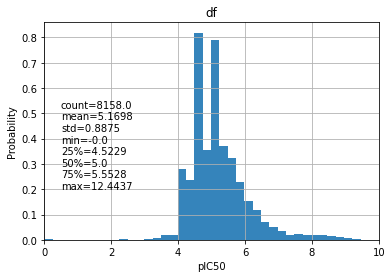

In [38]:
plot_pIC50(df1, name='df')

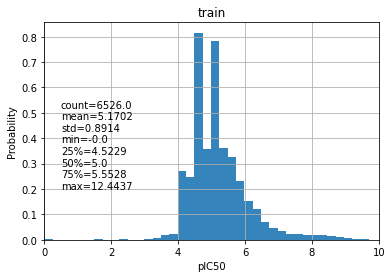

In [39]:
plot_pIC50(y_train, name="train")

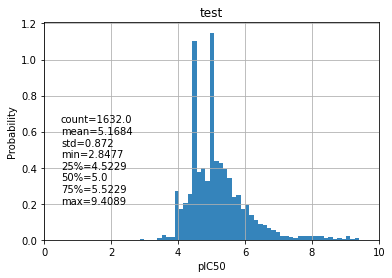

In [40]:
plot_pIC50(y_test, name= "test")

# Рассчитаем similarity между и внутри train&test

Вначале между тест и трэйн

In [41]:
Y = df1["class"]
X = df1
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, random_state=75, train_size=.8)

In [42]:
def calculate_tanimoto_matrix(X_train, X_test):
    # Для каждого значения из теста расчитает индекс Танимото с каждым соединением из трэйна. Получим матрицу.
    mols_train = list(X_train["ROMol"])
    mols_test = list(X_test["ROMol"])
    fp_mg2_bin = [AllChem.GetMorganFingerprintAsBitVect(m, 3, nBits=2048) for m in mols_train]
    fp_mg2_bin_test = [AllChem.GetMorganFingerprintAsBitVect(m, 3, nBits=2048) for m in mols_test]
    df = pd.DataFrame(index=range(1),columns=range(len(X_train)))
    for idx in range(len(fp_mg2_bin_test)):
        tanimoto_mg2_bin = DataStructs.BulkTanimotoSimilarity(fp_mg2_bin_test[idx], [fp for i, fp in enumerate(fp_mg2_bin)])
        df_length = len(df)
        df.loc[df_length] = tanimoto_mg2_bin
    df = df.iloc[1: , :]
    return(df, mols_test, mols_train, fp_mg2_bin, fp_mg2_bin_test)

In [43]:
df, mols_test, mols_train, fp_mg2_bin, fp_mg2_bin_test = calculate_tanimoto_matrix(X_train, X_test)

In [22]:
df

,0,1,2,3,4,5,6,7,8,9,...,6516,6517,6518,6519,6520,6521,6522,6523,6524,6525
1,0.104895,0.101351,0.086957,0.087838,0.044643,0.120301,0.102941,0.047170,0.140741,0.052632,...,0.100840,0.098039,0.097561,0.100840,0.094891,0.102190,0.162393,0.108696,0.125000,0.068966
2,0.096154,0.079755,0.101351,0.087500,0.056911,0.080000,0.108844,0.068966,0.105960,0.090164,...,0.099237,0.077381,0.080292,0.066667,0.164286,0.197080,0.120301,0.099338,0.077519,0.062016
3,0.116883,0.127389,0.123288,0.093750,0.039683,0.101351,0.078947,0.059322,0.105263,0.055118,...,0.074074,0.096386,0.111940,0.098485,0.064935,0.107383,0.127820,0.113333,0.157025,0.104000
4,0.075758,0.065217,0.063492,0.074074,0.052083,0.047244,0.063492,0.067416,0.069767,0.040000,...,0.045455,0.055556,0.112150,0.055046,0.055118,0.054688,0.061947,0.062016,0.078431,0.080000
5,0.111801,0.095238,0.089172,0.103030,0.112903,0.103896,0.089172,0.064516,0.136364,0.093023,...,0.125926,0.092486,0.098592,0.093525,0.096154,0.109677,0.060811,0.115385,0.080882,0.058394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,0.092715,0.096774,0.121429,0.083871,0.059829,0.090909,0.097902,0.063063,0.118056,0.049587,...,0.061538,0.121795,0.100775,0.104000,0.082759,0.089655,0.125984,0.095890,0.108333,0.082645
1629,0.115385,0.084848,0.106667,0.106250,0.081301,0.130137,0.160839,0.049587,0.148649,0.088000,...,0.105263,0.095238,0.094203,0.113636,0.114094,0.105960,0.078014,0.149660,0.100775,0.052632
1630,0.098592,0.102740,0.096296,0.089041,0.055046,0.080882,0.080292,0.112245,0.093525,0.044248,...,0.084034,0.114094,0.090164,0.121739,0.104478,0.071942,0.116667,0.086331,0.158879,0.089286
1631,0.125000,0.108571,0.064706,0.090909,0.088235,0.125000,0.138365,0.044118,0.141975,0.086331,...,0.087248,0.124294,0.092105,0.125000,0.138365,0.137500,0.105960,0.128834,0.097902,0.047297


In [24]:
#  Сортируем и выбираем максимальные значения индекса Танимото по каждой строчке

In [25]:
df1_sort = df.max(axis = 1)
df1_sort

1       0.802817
2       0.768293
3       0.677778
4       0.483871
5       0.829787
          ...   
1628    0.662500
1629    0.766667
1630    0.279070
1631    0.798077
1632    0.813953
Length: 1632, dtype: float64

In [26]:
def count_tanimoto_range_3(df1, dot1, dot2):
    # данная функция расчитывает диапазон по индексу Танимото, куда попали пары соедиений. Диапазон из 3 частей.
    count_ = Counter()
    for i in df1:
        if i <= dot1:
            count_[f"Tanimoto_index = 0.00 - {dot1}"]+=1
        elif i <= dot2 and i > dot1:
            count_[f"Tanimoto_index = {dot1} - {dot2}"]+=1
        elif i >  dot2:
            count_[f"Tanimoto_index = {dot2} - 1.00"]+=1
    return count_

In [27]:
count_ = count_tanimoto_range_3(df1_sort, 0.33, 0.66)
print(count_)

Counter({'Tanimoto_index = 0.66 - 1.00': 1114, 'Tanimoto_index = 0.33 - 0.66': 425, 'Tanimoto_index = 0.00 - 0.33': 93})


In [28]:
def count_tanimoto_range_2(df1, dot1):
    # Функция показывает число соединений в диапазоне dot1-1.0.
    count_ = Counter()
    for i in df1:
        if i > dot1:
            count_[f"Tanimoto_index = {dot1} - 1.00"]+=1
    return count_

In [29]:
count_ = count_tanimoto_range_2(df1_sort, 0.8)
print(count_)

Counter({'Tanimoto_index = 0.8 - 1.00': 369})


In [30]:
def plot_pIC50_sort(df1_sort, name):
    # функция для построения распределения по значению индекса Танимото для пар соединений тест-трэйн
    c,me,std,mi,procent1, procent2, procent3, ma = df1_sort.describe().round(4)
    n, bins, patches = plt.hist(df1_sort, 50, density=True, alpha=0.9)

    plt.xlabel('Tanimoto_index')
    plt.ylabel('Probability')
    plt.title(f'{name}')
    plt.xlim(0, 1)
    plt.annotate(f'count={c}\nmean={me}\nstd={std}\nmin={mi}\n25%={procent1}\n50%={procent2}\n75%={procent3}\nmax={ma}', xy=(0.3, 1.5))
    # plt.ylim(0, 1)
    plt.grid(True)
    plt.show()
    

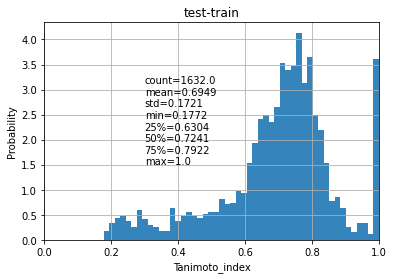

In [31]:
plot_pIC50_sort(df1_sort, name='test-train')

разберемся с теми соединениями, у которых индекс Танимото = 1

In [32]:
data = sum(np.where(df1_sort != 1, 0, 1))
data

93

93 соединения из теста имеют индекс Танимото = 1 с трэйном.

Функция, котрая сравнивает все соединения из трэйн и из теста по классу активности и по разнице в IC50_nM

In [35]:
# Функция, котрая сравнивает все соединения из трэйн и из теста по классу активности и по разнице в IC50_nM
def stereo_review_calc(df, X_train, X_test):
    df2_sort = df.max(axis = 0) # отбираем максимальные значения индекса Танимото в трэйне
    index_tanimoto_1_train = []
    for index, value in df2_sort.items(): #отбираем индексы тех соединений трэйна, для которых idT = 1.0 c некоторыми соединениями теста
        if value == 1.0:
            index_tanimoto_1_train.append(index)
    X_train.reset_index(drop=True, inplace=True) #обнуляем индексы у трэйна и теста, поскольку при генерации молекул из них индексы обнулялись(см функцию calculate_tanimoto_matrix генерация mols_train, mols_test)
    X_test.reset_index(drop=True, inplace=True)
    stereo_review = 0 # счетчик кол-ва стереоизомеров с одинаковой активностью по классу (1/0)
    stereo_review_diff = 0 # счетчик кол-ва стереоизомеров с разной активностью по классу (1/0)
    IC50_nM_diff = [] # будут записаны разницы в активности у стереизомеров в nM (IC50)
    s_same = pd.Series([0], index = [0]) # будет словарик с индексами из трэйна и теста тех пар стереоизомеров, чей класс активноси одинаков
    s_diff = pd.Series([0], index = [0]) # будет словарик с индексами из трэйна и теста тех пар стереоизмеров, чей класс активноси разный
    for train in index_tanimoto_1_train: # цикл для того, чтобы понять какое именно соединение(индекс) из теста соответствует данному индексу из трэйна (т.е. составление пар стереоизмеров(словаря))
        #train = [i]
        number_of_others=0 # число других соединений теста, у которых при построении tanimoto_matrix не встречалось значение 1.0
        test = []
        for index, row in df.iterrows():
            value = row[train]
            if value == 1.0:
                test.append(index-1)
            else:
                number_of_others+=1
        dict_stereo = pd.Series([int(test[0])], index=[train])
        # проверка: в результате данного цикла мы должны были оторать пару стереоизмеров (тест-трэйн). Т.е. число других в тесте должно быть len(X_test)-1.
        if number_of_others == len(X_test)-1:
            if int(X_train.loc[[train], "class"]) == int(X_test.loc[[int(test[0])], "class"]):
                stereo_review += 1               
                s_same = s_same.append(dict_stereo)
            else:
                stereo_review_diff +=1
                s_diff = s_diff.append(dict_stereo)
            diff = abs(float(X_train.loc[[train], "value_nM"])- float(X_test.loc[[int(test[0])], "class"]))
            IC50_nM_diff.append(diff)
        else: # но бывает, что на одно соединение в трэйне приходятся аж два стереоизомера из теста, это тоже надо учесть. В таком случае далее в списке test у нас будет list из двух значений (двух индексов)
            if (len(X_test)-1)-number_of_others == 1:
                if int(X_train.loc[[train], "class"]) == int(X_test.loc[[int(test[0])], "class"]):
                    stereo_review += 1
                    s_same = s_same.append(dict_stereo)
                else:
                    stereo_review_diff +=1
                    s_diff = s_diff.append(dict_stereo)
                diff = abs(float(X_train.loc[[train], "value_nM"])- float(X_test.loc[[int(test[0])], "class"]))
                IC50_nM_diff.append(diff)
                dict_stereo_3 = pd.Series([int(test[1])], index=[train])
                if int(X_train.loc[[train], "class"]) == int(X_test.loc[[int(test[1])], "class"]):
                    stereo_review += 1
                    s_same = s_same.append(dict_stereo_3)
                else:
                    stereo_review_diff +=1
                    s_diff = s_diff.append(dict_stereo_3)
                diff = abs(float(X_train.loc[[train], "value_nM"])- float(X_test.loc[[int(test[1])], "class"]))
                IC50_nM_diff.append(diff)
    del s_same[0]
    del s_diff[0]
    return(stereo_review,stereo_review_diff,IC50_nM_diff,index_tanimoto_1_train,s_same,s_diff)
            

In [36]:
stereo_rewiew,stereo_rewiew_diff,IC50_nM_diff,index_tanimoto_1_train,s_same,s_diff  = stereo_review_calc(df, X_train, X_test)

In [37]:
print (f"Number of compounds with the same IC50 class = {stereo_rewiew}")
print (f"Number of compound with the different IC50 class = {stereo_rewiew_diff}")
print (f"Mean of difference in IC50 nM = {np.mean(IC50_nM_diff)}")

Number of compounds with the same IC50 class = 98
Number of compound with the different IC50 class = 20
Mean of difference in IC50 nM = 33583.31813559322


Далее слева - индекс трэйна, справа - теста

In [38]:
len(s_diff)

20

In [39]:
s_diff

453     1020
672      646
687      469
826      248
859     1586
1499    1419
2288    1586
2671    1401
2822    1368
3898     723
4033      28
4080    1354
4148     703
4246     878
4379     469
4585    1246
4825     872
5595    1401
5827    1209
6314     182
dtype: int64

In [40]:
s_diff.to_csv("s_diff.csv", encoding='utf-8', index=True)

Взглянем на стереомеры, различные по активности:

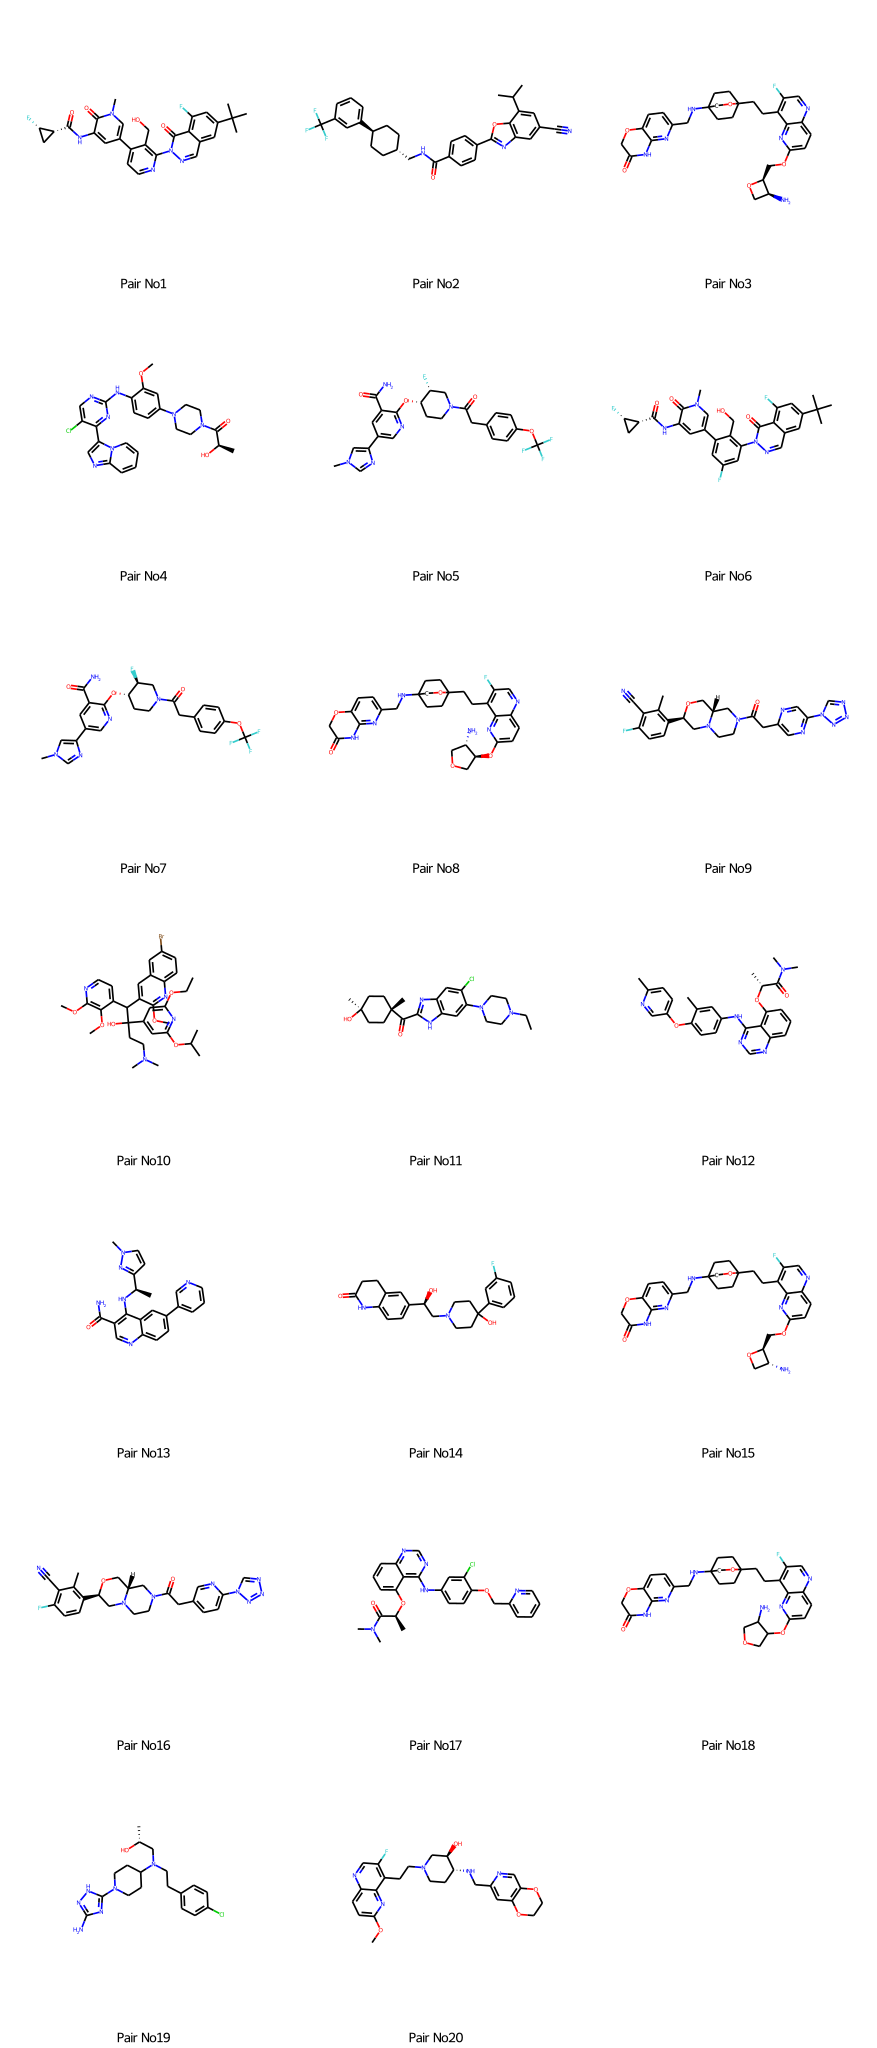

In [54]:
legend = ['Pair No' + str(i+1) for i in range(21)]
Draw.MolsToGridImage([mols_train[i] for i in s_diff.keys()], subImgSize=(350, 350), legends=legend, molsPerRow=3)

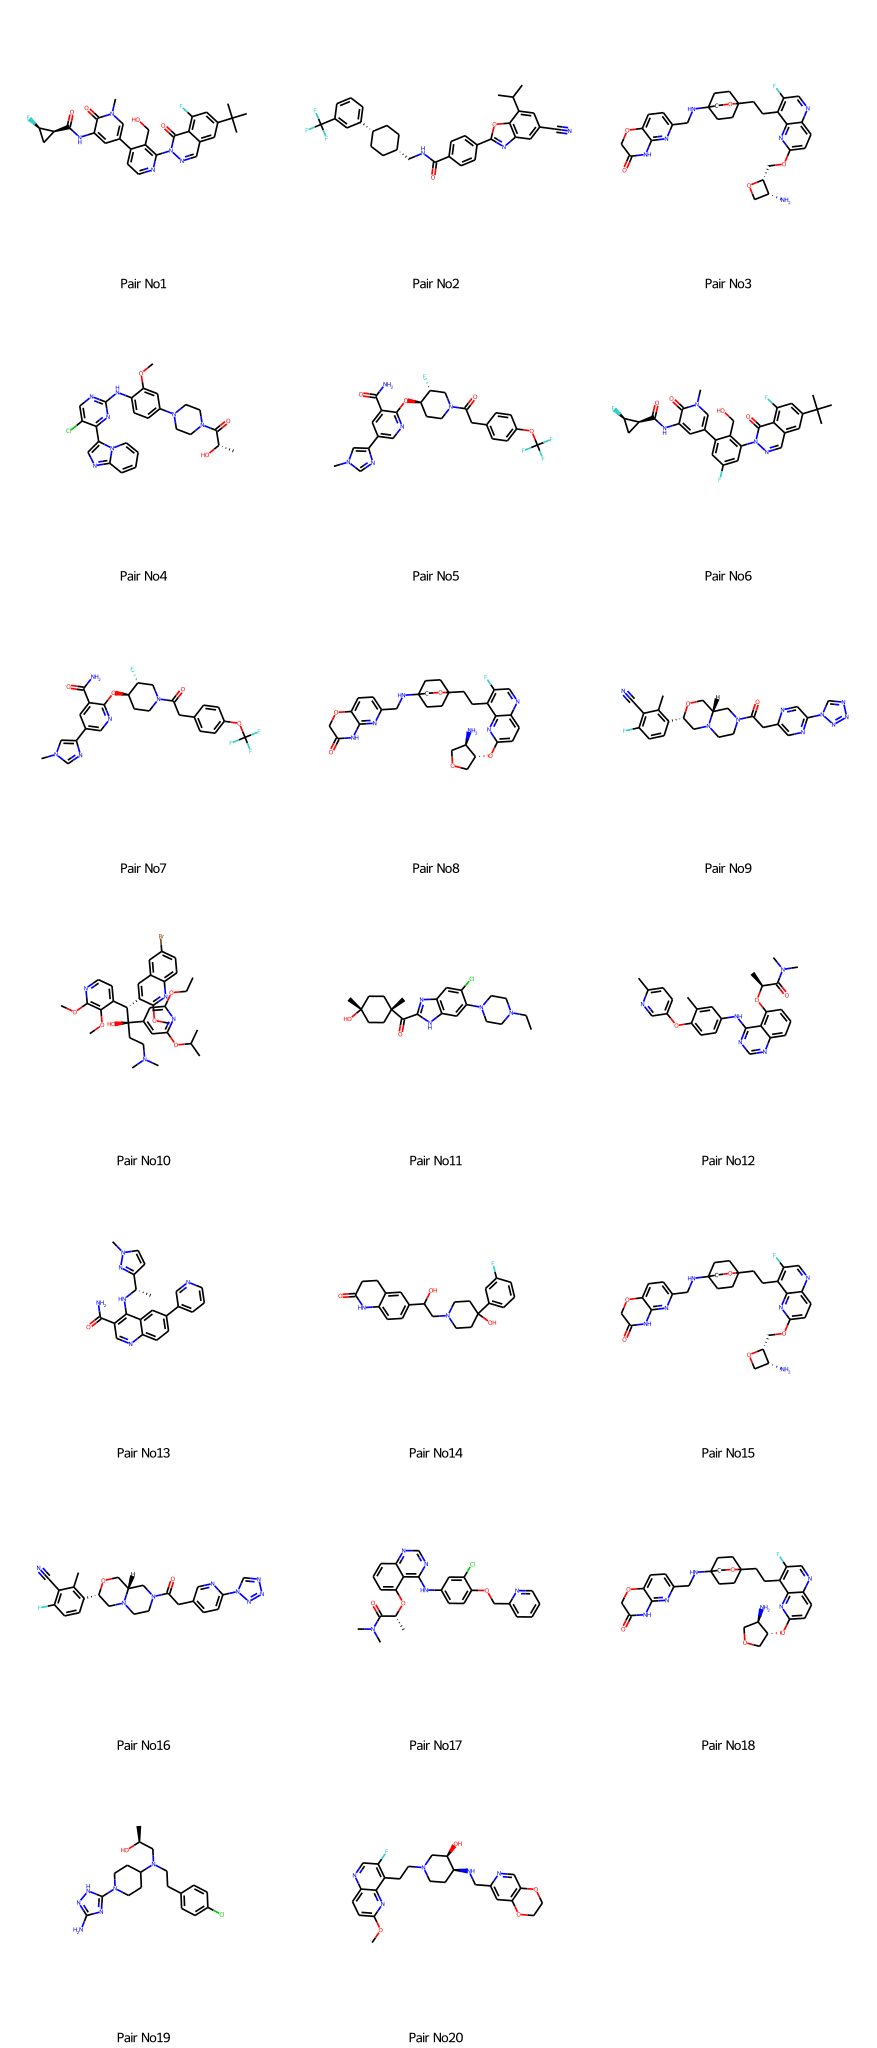

In [56]:
legend = ['Pair No' + str(i+1) for i in range(21)]
Draw.MolsToGridImage([mols_test[i] for i in s_diff.values], subImgSize=(350, 350), legends=legend, molsPerRow=3)

In [43]:
X_train.loc[[453]]

,canonical_smiles,molecule_chembl_id,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class,pIC50
453,Cn1cc(-c2ccnc(-n3ncc4cc(C(C)(C)C)cc(F)c4c3=O)c...,CHEMBL4634904,=,IC50,nM,uM,1.3,535.551,1300.0,1,5.886057


In [44]:
X_test.loc[[1020]]

,canonical_smiles,molecule_chembl_id,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class,pIC50
1020,Cn1cc(-c2ccnc(-n3ncc4cc(C(C)(C)C)cc(F)c4c3=O)c...,CHEMBL4648439,>,IC50,nM,uM,10.0,535.551,10000.0,0,5.0


,canonical_smiles,molecule_chembl_id,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class,pIC50,ID,ROMol
1,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,CHEMBL1108,=,IC50,nM,nM,32.2,379.435,32.2,1,7.492144,,

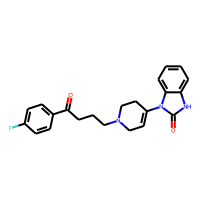

In [45]:
X_train.loc[[1]]

,canonical_smiles,molecule_chembl_id,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class,pIC50,ID,ROMol
4145,CCN1CCN(CC(=O)Nc2ccc(-c3cccc4c(=O)cc(N5CCOCC5)...,CHEMBL1086377,>,IC50,nM,uM,20.0,582.726,20000.0,0,4.69897,,

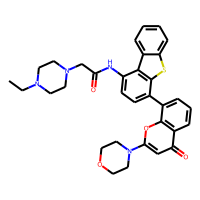

In [46]:
X_train.iloc[[1]]

In [45]:
# pd.set_option('display.max_colwidth', None) # 0 - чтобы обратно сокращал, чтобы посмотреть полный smiles, проверить

In [46]:
# n = DataStructs.FingerprintSimilarity(fp_mg2_bin[int(train[0])], fp_mg2_bin_test[int(test[0])]) проверить, какой индекс у двух молекул

# Вернемся к similarity

Теперь рассчитаем similarity внутри трэйна и теста

Внутри теста:

In [47]:
def calculate_tanimoto_matrix_inside(X_test, fp_mg2_bin_test):
# Помимо работы calculate_tanimoto_matrix, данная функция также обнуляет значения по диагонали (они нам не интересны, это индекс Танимото соединения самого с собой, равен 1.0), а также расчитывает и выводит время расчетов (актуально для больших датасетов)
    df = pd.DataFrame(index=range(1),columns=range(len(X_test)))
    t0 = time.time()
    for idx in range(len(fp_mg2_bin_test)):
        t1 = time.time()
        print("Processing compound {} ({}%)".format(idx, 100*idx//len(fp_mg2_bin_test)), end="")
        tanimoto_mg2_bin = DataStructs.BulkTanimotoSimilarity(fp_mg2_bin_test[idx], [fp for i, fp in enumerate(fp_mg2_bin_test)])
        df_length = len(df)
        df.loc[df_length] = tanimoto_mg2_bin
        t2 = time.time()
        print(" {}s (total: {}s)".format(t2-t1, t2-t0))
    df = df.iloc[1: , :]
    df1 = df.where(df.values != np.diag(df),0,df.where(df.values != np.flipud(df).diagonal(0),0,inplace=True))
    return (df1)

In [48]:
df1 = calculate_tanimoto_matrix_inside(X_test, fp_mg2_bin_test)

Processing compound 0 (0%) 0.004948854446411133s (total: 0.004951953887939453s)
Processing compound 1 (0%) 0.0023589134216308594s (total: 0.007503032684326172s)
Processing compound 2 (0%) 0.0026111602783203125s (total: 0.010275125503540039s)
Processing compound 3 (0%) 0.0031309127807617188s (total: 0.013511896133422852s)
Processing compound 4 (0%) 0.002604961395263672s (total: 0.016334056854248047s)
Processing compound 5 (0%) 0.0026090145111083984s (total: 0.019115924835205078s)
Processing compound 6 (0%) 0.002465963363647461s (total: 0.02178502082824707s)
Processing compound 7 (0%) 0.0024929046630859375s (total: 0.02449798583984375s)
Processing compound 8 (0%) 0.002505064010620117s (total: 0.027306079864501953s)
Processing compound 9 (0%) 0.003082275390625s (total: 0.03065013885498047s)
Processing compound 10 (0%) 0.0023260116577148438s (total: 0.033210039138793945s)
Processing compound 11 (0%) 0.002458810806274414s (total: 0.03587985038757324s)
Processing compound 12 (0%) 0.002476930

Processing compound 127 (7%) 0.003271818161010742s (total: 0.4213109016418457s)
Processing compound 128 (7%) 0.003802061080932617s (total: 0.425199031829834s)
Processing compound 129 (7%) 0.0047931671142578125s (total: 0.43009519577026367s)
Processing compound 130 (7%) 0.003515958786010742s (total: 0.4337179660797119s)
Processing compound 131 (8%) 0.003525257110595703s (total: 0.4373340606689453s)
Processing compound 132 (8%) 0.003489971160888672s (total: 0.4409139156341553s)
Processing compound 133 (8%) 0.003777742385864258s (total: 0.4448058605194092s)
Processing compound 134 (8%) 0.004603862762451172s (total: 0.4495539665222168s)
Processing compound 135 (8%) 0.003951072692871094s (total: 0.4536020755767822s)
Processing compound 136 (8%) 0.005562782287597656s (total: 0.4592719078063965s)
Processing compound 137 (8%) 0.006103038787841797s (total: 0.46552181243896484s)
Processing compound 138 (8%) 0.005002021789550781s (total: 0.47066712379455566s)
Processing compound 139 (8%) 0.003679

Processing compound 260 (15%) 0.0054149627685546875s (total: 1.044346809387207s)
Processing compound 261 (15%) 0.00515294075012207s (total: 1.0497000217437744s)
Processing compound 262 (16%) 0.004930973052978516s (total: 1.0547339916229248s)
Processing compound 263 (16%) 0.004939079284667969s (total: 1.059762954711914s)
Processing compound 264 (16%) 0.005852222442626953s (total: 1.0657222270965576s)
Processing compound 265 (16%) 0.005557060241699219s (total: 1.0714070796966553s)
Processing compound 266 (16%) 0.0058329105377197266s (total: 1.0773849487304688s)
Processing compound 267 (16%) 0.006767988204956055s (total: 1.0843169689178467s)
Processing compound 268 (16%) 0.005770206451416016s (total: 1.090287208557129s)
Processing compound 269 (16%) 0.006104946136474609s (total: 1.0965709686279297s)
Processing compound 270 (16%) 0.007035017013549805s (total: 1.1038060188293457s)
Processing compound 271 (16%) 0.0051860809326171875s (total: 1.1091530323028564s)
Processing compound 272 (16%)

Processing compound 367 (22%) 0.006554126739501953s (total: 1.6648130416870117s)
Processing compound 368 (22%) 0.006154060363769531s (total: 1.6711039543151855s)
Processing compound 369 (22%) 0.006103992462158203s (total: 1.6773219108581543s)
Processing compound 370 (22%) 0.0065991878509521484s (total: 1.6840691566467285s)
Processing compound 371 (22%) 0.007036924362182617s (total: 1.6912269592285156s)
Processing compound 372 (22%) 0.007645845413208008s (total: 1.6990299224853516s)
Processing compound 373 (22%) 0.0065479278564453125s (total: 1.705777883529663s)
Processing compound 374 (22%) 0.006247043609619141s (total: 1.712162971496582s)
Processing compound 375 (22%) 0.006300210952758789s (total: 1.7186920642852783s)
Processing compound 376 (23%) 0.005579948425292969s (total: 1.7244338989257812s)
Processing compound 377 (23%) 0.00642085075378418s (total: 1.7309648990631104s)
Processing compound 378 (23%) 0.005934953689575195s (total: 1.7370529174804688s)
Processing compound 379 (23%)

Processing compound 487 (29%) 0.006994009017944336s (total: 2.490133047103882s)
Processing compound 488 (29%) 0.0075490474700927734s (total: 2.497796058654785s)
Processing compound 489 (29%) 0.0073850154876708984s (total: 2.50529408454895s)
Processing compound 490 (30%) 0.008855104446411133s (total: 2.5142951011657715s)
Processing compound 491 (30%) 0.007179975509643555s (total: 2.5216498374938965s)
Processing compound 492 (30%) 0.007279872894287109s (total: 2.5290749073028564s)
Processing compound 493 (30%) 0.008807897567749023s (total: 2.5380568504333496s)
Processing compound 494 (30%) 0.007534980773925781s (total: 2.5457470417022705s)
Processing compound 495 (30%) 0.007086992263793945s (total: 2.552994966506958s)
Processing compound 496 (30%) 0.007555961608886719s (total: 2.5606980323791504s)
Processing compound 497 (30%) 0.007821083068847656s (total: 2.568650007247925s)
Processing compound 498 (30%) 0.008213043212890625s (total: 2.57700514793396s)
Processing compound 499 (30%) 0.00

Processing compound 611 (37%) 0.008583307266235352s (total: 3.5344021320343018s)
Processing compound 612 (37%) 0.008272171020507812s (total: 3.5428500175476074s)
Processing compound 613 (37%) 0.009669780731201172s (total: 3.5529868602752686s)
Processing compound 614 (37%) 0.008916139602661133s (total: 3.5620219707489014s)
Processing compound 615 (37%) 0.009192943572998047s (total: 3.5713419914245605s)
Processing compound 616 (37%) 0.008603811264038086s (total: 3.580169916152954s)
Processing compound 617 (37%) 0.008767127990722656s (total: 3.5890939235687256s)
Processing compound 618 (37%) 0.010192155838012695s (total: 3.599407196044922s)
Processing compound 619 (37%) 0.00887608528137207s (total: 3.6084511280059814s)
Processing compound 620 (37%) 0.009443998336791992s (total: 3.6180670261383057s)
Processing compound 621 (38%) 0.008978843688964844s (total: 3.627227783203125s)
Processing compound 622 (38%) 0.007998943328857422s (total: 3.635711908340454s)
Processing compound 623 (38%) 0.0

Processing compound 721 (44%) 0.009290933609008789s (total: 4.571897029876709s)
Processing compound 722 (44%) 0.009919881820678711s (total: 4.581943035125732s)
Processing compound 723 (44%) 0.009837150573730469s (total: 4.591905117034912s)
Processing compound 724 (44%) 0.010641813278198242s (total: 4.602768898010254s)
Processing compound 725 (44%) 0.009634256362915039s (total: 4.61255407333374s)
Processing compound 726 (44%) 0.01009988784790039s (total: 4.6227898597717285s)
Processing compound 727 (44%) 0.010513067245483398s (total: 4.63346004486084s)
Processing compound 728 (44%) 0.010389089584350586s (total: 4.644032001495361s)
Processing compound 729 (44%) 0.01044607162475586s (total: 4.654680967330933s)
Processing compound 730 (44%) 0.009853124618530273s (total: 4.664685010910034s)
Processing compound 731 (44%) 0.009956836700439453s (total: 4.674800872802734s)
Processing compound 732 (44%) 0.009937286376953125s (total: 4.6849541664123535s)
Processing compound 733 (44%) 0.0096518993

Processing compound 839 (51%) 0.011441230773925781s (total: 5.821527004241943s)
Processing compound 840 (51%) 0.011111021041870117s (total: 5.83276104927063s)
Processing compound 841 (51%) 0.01113438606262207s (total: 5.8440351486206055s)
Processing compound 842 (51%) 0.01373291015625s (total: 5.858057022094727s)
Processing compound 843 (51%) 0.012472152709960938s (total: 5.870666980743408s)
Processing compound 844 (51%) 0.012602090835571289s (total: 5.883503198623657s)
Processing compound 845 (51%) 0.012160062789916992s (total: 5.8957839012146s)
Processing compound 846 (51%) 0.011546850204467773s (total: 5.907572031021118s)
Processing compound 847 (51%) 0.012719869613647461s (total: 5.920444011688232s)
Processing compound 848 (51%) 0.011773824691772461s (total: 5.93234395980835s)
Processing compound 849 (52%) 0.012336969375610352s (total: 5.944805860519409s)
Processing compound 850 (52%) 0.011644840240478516s (total: 5.956658840179443s)
Processing compound 851 (52%) 0.0122809410095214

Processing compound 945 (57%) 0.01211404800415039s (total: 7.082143068313599s)
Processing compound 946 (57%) 0.012365102767944336s (total: 7.094637155532837s)
Processing compound 947 (58%) 0.012503862380981445s (total: 7.107343912124634s)
Processing compound 948 (58%) 0.012346982955932617s (total: 7.119848966598511s)
Processing compound 949 (58%) 0.011754035949707031s (total: 7.131724119186401s)
Processing compound 950 (58%) 0.012241125106811523s (total: 7.144122123718262s)
Processing compound 951 (58%) 0.01125192642211914s (total: 7.155535936355591s)
Processing compound 952 (58%) 0.012294292449951172s (total: 7.167992115020752s)
Processing compound 953 (58%) 0.012257099151611328s (total: 7.180433988571167s)
Processing compound 954 (58%) 0.0117340087890625s (total: 7.1923508644104s)
Processing compound 955 (58%) 0.012156963348388672s (total: 7.2046568393707275s)
Processing compound 956 (58%) 0.011779069900512695s (total: 7.216595888137817s)
Processing compound 957 (58%) 0.0115790367126

Processing compound 1061 (65%) 0.013614892959594727s (total: 8.551846981048584s)
Processing compound 1062 (65%) 0.012794971466064453s (total: 8.564765930175781s)
Processing compound 1063 (65%) 0.013966083526611328s (total: 8.578853130340576s)
Processing compound 1064 (65%) 0.01578807830810547s (total: 8.594779968261719s)
Processing compound 1065 (65%) 0.014628171920776367s (total: 8.609589099884033s)
Processing compound 1066 (65%) 0.013793706893920898s (total: 8.623514890670776s)
Processing compound 1067 (65%) 0.012888193130493164s (total: 8.636526107788086s)
Processing compound 1068 (65%) 0.012685060501098633s (total: 8.649368047714233s)
Processing compound 1069 (65%) 0.012394905090332031s (total: 8.661886930465698s)
Processing compound 1070 (65%) 0.012689828872680664s (total: 8.674954891204834s)
Processing compound 1071 (65%) 0.015069007873535156s (total: 8.690165042877197s)
Processing compound 1072 (65%) 0.013941049575805664s (total: 8.704287052154541s)
Processing compound 1073 (65%

Processing compound 1164 (71%) 0.014241933822631836s (total: 10.03734803199768s)
Processing compound 1165 (71%) 0.01404118537902832s (total: 10.051520109176636s)
Processing compound 1166 (71%) 0.014021873474121094s (total: 10.065669775009155s)
Processing compound 1167 (71%) 0.013983011245727539s (total: 10.079783916473389s)
Processing compound 1168 (71%) 0.013722896575927734s (total: 10.093660831451416s)
Processing compound 1169 (71%) 0.013946056365966797s (total: 10.107775926589966s)
Processing compound 1170 (71%) 0.013661861419677734s (total: 10.121603012084961s)
Processing compound 1171 (71%) 0.013429880142211914s (total: 10.135187864303589s)
Processing compound 1172 (71%) 0.013557195663452148s (total: 10.148863077163696s)
Processing compound 1173 (71%) 0.012784957885742188s (total: 10.161799907684326s)
Processing compound 1174 (71%) 0.01293802261352539s (total: 10.174865007400513s)
Processing compound 1175 (71%) 0.013212919235229492s (total: 10.188228845596313s)
Processing compound

Processing compound 1277 (78%) 0.016510963439941406s (total: 11.72223687171936s)
Processing compound 1278 (78%) 0.01605987548828125s (total: 11.738470792770386s)
Processing compound 1279 (78%) 0.01632523536682129s (total: 11.754937171936035s)
Processing compound 1280 (78%) 0.015801191329956055s (total: 11.770893096923828s)
Processing compound 1281 (78%) 0.015538930892944336s (total: 11.786570072174072s)
Processing compound 1282 (78%) 0.015464067459106445s (total: 11.8022301197052s)
Processing compound 1283 (78%) 0.014414072036743164s (total: 11.816799879074097s)
Processing compound 1284 (78%) 0.014659881591796875s (total: 11.831614017486572s)
Processing compound 1285 (78%) 0.014482736587524414s (total: 11.846314907073975s)
Processing compound 1286 (78%) 0.015503883361816406s (total: 11.861939907073975s)
Processing compound 1287 (78%) 0.015830039978027344s (total: 11.877902030944824s)
Processing compound 1288 (78%) 0.014445066452026367s (total: 11.892596006393433s)
Processing compound 1

Processing compound 1383 (84%) 0.016117095947265625s (total: 13.435785055160522s)
Processing compound 1384 (84%) 0.016335248947143555s (total: 13.45224404335022s)
Processing compound 1385 (84%) 0.016555070877075195s (total: 13.46898102760315s)
Processing compound 1386 (84%) 0.015633821487426758s (total: 13.48476791381836s)
Processing compound 1387 (84%) 0.016108036041259766s (total: 13.501024961471558s)
Processing compound 1388 (85%) 0.016738176345825195s (total: 13.517920017242432s)
Processing compound 1389 (85%) 0.016098737716674805s (total: 13.534170866012573s)
Processing compound 1390 (85%) 0.017361879348754883s (total: 13.551743984222412s)
Processing compound 1391 (85%) 0.019954919815063477s (total: 13.571878910064697s)
Processing compound 1392 (85%) 0.01724076271057129s (total: 13.589264869689941s)
Processing compound 1393 (85%) 0.016826868057250977s (total: 13.606212854385376s)
Processing compound 1394 (85%) 0.016664981842041016s (total: 13.622995853424072s)
Processing compound 

Processing compound 1490 (91%) 0.018379688262939453s (total: 15.351301908493042s)
Processing compound 1491 (91%) 0.018383264541625977s (total: 15.369818210601807s)
Processing compound 1492 (91%) 0.019779205322265625s (total: 15.389753103256226s)
Processing compound 1493 (91%) 0.01862502098083496s (total: 15.40859603881836s)
Processing compound 1494 (91%) 0.017847061157226562s (total: 15.426624059677124s)
Processing compound 1495 (91%) 0.01885986328125s (total: 15.445649862289429s)
Processing compound 1496 (91%) 0.019057273864746094s (total: 15.465005159378052s)
Processing compound 1497 (91%) 0.019426822662353516s (total: 15.484572887420654s)
Processing compound 1498 (91%) 0.018476009368896484s (total: 15.503183126449585s)
Processing compound 1499 (91%) 0.01955103874206543s (total: 15.52287483215332s)
Processing compound 1500 (91%) 0.01855778694152832s (total: 15.541611909866333s)
Processing compound 1501 (91%) 0.020793914794921875s (total: 15.562597036361694s)
Processing compound 1502 

Processing compound 1599 (97%) 0.02233600616455078s (total: 17.514384984970093s)
Processing compound 1600 (98%) 0.01905989646911621s (total: 17.533577919006348s)
Processing compound 1601 (98%) 0.0189969539642334s (total: 17.552806854248047s)
Processing compound 1602 (98%) 0.019787073135375977s (total: 17.572728157043457s)
Processing compound 1603 (98%) 0.019555091857910156s (total: 17.592445850372314s)
Processing compound 1604 (98%) 0.019792795181274414s (total: 17.612403869628906s)
Processing compound 1605 (98%) 0.020247936248779297s (total: 17.632783889770508s)
Processing compound 1606 (98%) 0.021064043045043945s (total: 17.653974056243896s)
Processing compound 1607 (98%) 0.020463228225708008s (total: 17.67457413673401s)
Processing compound 1608 (98%) 0.019828081130981445s (total: 17.694565057754517s)
Processing compound 1609 (98%) 0.018614768981933594s (total: 17.713371992111206s)
Processing compound 1610 (98%) 0.018473148345947266s (total: 17.73197293281555s)
Processing compound 16

/Users/elly/opt/anaconda3/envs/herg-model/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.where except for the arguments 'cond' and 'other' will be keyword-only
  


In [42]:
df1

,0,1,2,3,4,5,6,7,8,9,...,1622,1623,1624,1625,1626,1627,1628,1629,1630,1631
1,0.000000,0.069231,0.085271,0.067961,0.097015,0.078125,0.116071,0.100000,0.095652,0.111940,...,0.107692,0.124088,0.132231,0.050314,0.110169,0.127119,0.109375,0.097345,0.129496,0.000000
2,0.069231,0.000000,0.077465,0.069565,0.111111,0.094203,0.078125,0.091503,0.061069,0.125000,...,0.171642,0.098684,0.063830,0.090909,0.051095,0.097744,0.123188,0.078740,0.000000,0.101852
3,0.085271,0.077465,0.000000,0.059829,0.080537,0.109489,0.085938,0.120000,0.120000,0.093960,...,0.170370,0.105263,0.102190,0.077381,0.082090,0.113636,0.090909,0.000000,0.089172,0.081081
4,0.067961,0.069565,0.059829,0.000000,0.091667,0.042735,0.048077,0.061538,0.078431,0.081301,...,0.040650,0.053435,0.070796,0.055944,0.055046,0.073394,0.000000,0.069307,0.052239,0.046512
5,0.097015,0.111111,0.080537,0.091667,0.000000,0.060000,0.042857,0.107595,0.130769,0.133333,...,0.114865,0.093750,0.074830,0.093023,0.078014,0.000000,0.116438,0.082090,0.105590,0.058333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,0.127119,0.097744,0.113636,0.073394,0.000000,0.124031,0.090909,0.125874,0.072581,0.090909,...,0.094203,0.080537,0.090909,0.067485,0.078125,0.000000,0.071942,0.110169,0.093333,0.097087
1629,0.109375,0.123188,0.090909,0.000000,0.116438,0.054795,0.060150,0.125828,0.083969,0.130137,...,0.059603,0.096774,0.092857,0.129630,0.097015,0.071942,0.000000,0.076923,0.116129,0.079646
1630,0.097345,0.078740,0.000000,0.069307,0.082090,0.114754,0.088496,0.101449,0.137615,0.113636,...,0.083969,0.085714,0.097561,0.057692,0.075000,0.110169,0.076923,0.000000,0.091549,0.072165
1631,0.129496,0.000000,0.089172,0.052239,0.105590,0.049689,0.122302,0.101190,0.075342,0.139241,...,0.100629,0.141975,0.112583,0.093923,0.109589,0.093333,0.116129,0.091549,0.000000,0.122951


In [43]:
df1 = df1.max(axis = 1)
df1

1       0.518072
2       0.300000
3       0.582524
4       0.447761
5       0.770833
          ...   
1628    0.759494
1629    0.786517
1630    0.263736
1631    0.633333
1632    0.593220
Length: 1632, dtype: float64

In [46]:
count_ = count_tanimoto_range_3(df1, 0.33, 0.66)
print(count_)

Counter({'Tanimoto_index = 0.33 - 0.66': 693, 'Tanimoto_index = 0.66 - 1.00': 618, 'Tanimoto_index = 0.00 - 0.33': 321})


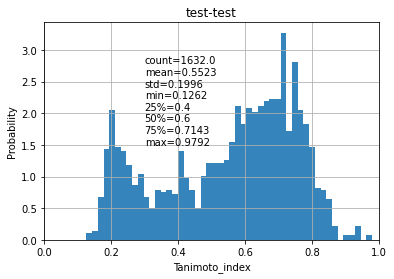

In [49]:
plot_pIC50_sort(df1, name='test-test')

То же самое для трэйна:

Осторожно, считается 14 минут. Т.е. увеличение датасета в 4 раза дает увеличение времени расчета в 50 раз... 

In [50]:
df1 = calculate_tanimoto_matrix_inside(X_train, fp_mg2_bin)

Processing compound 0 (0%) 0.014671087265014648s (total: 0.01467585563659668s)
Processing compound 1 (0%) 0.004512786865234375s (total: 0.019353866577148438s)
Processing compound 2 (0%) 0.004286050796508789s (total: 0.023836851119995117s)
Processing compound 3 (0%) 0.003979921340942383s (total: 0.02797985076904297s)
Processing compound 4 (0%) 0.003915071487426758s (total: 0.03205084800720215s)
Processing compound 5 (0%) 0.0037841796875s (total: 0.03599095344543457s)
Processing compound 6 (0%) 0.0037717819213867188s (total: 0.0399317741394043s)
Processing compound 7 (0%) 0.00415492057800293s (total: 0.04422879219055176s)
Processing compound 8 (0%) 0.0052471160888671875s (total: 0.04969596862792969s)
Processing compound 9 (0%) 0.00431370735168457s (total: 0.054169654846191406s)
Processing compound 10 (0%) 0.004327058792114258s (total: 0.05864691734313965s)
Processing compound 11 (0%) 0.0038640499114990234s (total: 0.06265497207641602s)
Processing compound 12 (0%) 0.0038299560546875s (tot

Processing compound 222 (3%) 0.011986255645751953s (total: 1.906830072402954s)
Processing compound 223 (3%) 0.012177228927612305s (total: 1.9191279411315918s)
Processing compound 224 (3%) 0.013072013854980469s (total: 1.9323198795318604s)
Processing compound 225 (3%) 0.011706829071044922s (total: 1.944178819656372s)
Processing compound 226 (3%) 0.012396812438964844s (total: 1.956697702407837s)
Processing compound 227 (3%) 0.012911796569824219s (total: 1.9697668552398682s)
Processing compound 228 (3%) 0.012335062026977539s (total: 1.9822609424591064s)
Processing compound 229 (3%) 0.01262211799621582s (total: 1.995039939880371s)
Processing compound 230 (3%) 0.012839078903198242s (total: 2.0080509185791016s)
Processing compound 231 (3%) 0.013124942779541016s (total: 2.021418809890747s)
Processing compound 232 (3%) 0.013202905654907227s (total: 2.0347838401794434s)
Processing compound 233 (3%) 0.01315617561340332s (total: 2.0480949878692627s)
Processing compound 234 (3%) 0.0122427940368652

Processing compound 429 (6%) 0.020730972290039062s (total: 5.34587287902832s)
Processing compound 430 (6%) 0.021786212921142578s (total: 5.367789030075073s)
Processing compound 431 (6%) 0.022228002548217773s (total: 5.390171766281128s)
Processing compound 432 (6%) 0.020939111709594727s (total: 5.411235809326172s)
Processing compound 433 (6%) 0.020960330963134766s (total: 5.432312965393066s)
Processing compound 434 (6%) 0.021598100662231445s (total: 5.454074859619141s)
Processing compound 435 (6%) 0.02214670181274414s (total: 5.476356744766235s)
Processing compound 436 (6%) 0.020446062088012695s (total: 5.496928930282593s)
Processing compound 437 (6%) 0.02052903175354004s (total: 5.517613887786865s)
Processing compound 438 (6%) 0.0199282169342041s (total: 5.537698030471802s)
Processing compound 439 (6%) 0.020417213439941406s (total: 5.558266878128052s)
Processing compound 440 (6%) 0.02158069610595703s (total: 5.579972743988037s)
Processing compound 441 (6%) 0.021441936492919922s (total:

Processing compound 640 (9%) 0.02792191505432129s (total: 10.560711860656738s)
Processing compound 641 (9%) 0.029299020767211914s (total: 10.590142965316772s)
Processing compound 642 (9%) 0.028252840042114258s (total: 10.61856985092163s)
Processing compound 643 (9%) 0.027791261672973633s (total: 10.646517992019653s)
Processing compound 644 (9%) 0.028133153915405273s (total: 10.674818992614746s)
Processing compound 645 (9%) 0.027782917022705078s (total: 10.702723741531372s)
Processing compound 646 (9%) 0.027412891387939453s (total: 10.7302987575531s)
Processing compound 647 (9%) 0.027461767196655273s (total: 10.757914781570435s)
Processing compound 648 (9%) 0.027724027633666992s (total: 10.785792827606201s)
Processing compound 649 (9%) 0.029617786407470703s (total: 10.815536737442017s)
Processing compound 650 (9%) 0.028536081314086914s (total: 10.844235897064209s)
Processing compound 651 (9%) 0.028244972229003906s (total: 10.872636795043945s)
Processing compound 652 (9%) 0.0275771617889

Processing compound 847 (12%) 0.036768198013305664s (total: 17.250886917114258s)
Processing compound 848 (12%) 0.03572797775268555s (total: 17.28679084777832s)
Processing compound 849 (13%) 0.03619813919067383s (total: 17.323145866394043s)
Processing compound 850 (13%) 0.03474688529968262s (total: 17.35805368423462s)
Processing compound 851 (13%) 0.03559565544128418s (total: 17.39380669593811s)
Processing compound 852 (13%) 0.03546714782714844s (total: 17.429422855377197s)
Processing compound 853 (13%) 0.037114858627319336s (total: 17.466693878173828s)
Processing compound 854 (13%) 0.03568696975708008s (total: 17.50250482559204s)
Processing compound 855 (13%) 0.03567814826965332s (total: 17.538339853286743s)
Processing compound 856 (13%) 0.03623390197753906s (total: 17.574731826782227s)
Processing compound 857 (13%) 0.03437185287475586s (total: 17.60925269126892s)
Processing compound 858 (13%) 0.031893014907836914s (total: 17.641308784484863s)
Processing compound 859 (13%) 0.0363652706

Processing compound 955 (14%) 0.040763139724731445s (total: 21.35116696357727s)
Processing compound 956 (14%) 0.04034304618835449s (total: 21.391702890396118s)
Processing compound 957 (14%) 0.0407559871673584s (total: 21.432586908340454s)
Processing compound 958 (14%) 0.043238162994384766s (total: 21.475959062576294s)
Processing compound 959 (14%) 0.03757190704345703s (total: 21.513662815093994s)
Processing compound 960 (14%) 0.039852142333984375s (total: 21.553642988204956s)
Processing compound 961 (14%) 0.041915178298950195s (total: 21.595726013183594s)
Processing compound 962 (14%) 0.040228843688964844s (total: 21.636114835739136s)
Processing compound 963 (14%) 0.039071083068847656s (total: 21.675342798233032s)
Processing compound 964 (14%) 0.03968191146850586s (total: 21.715179920196533s)
Processing compound 965 (14%) 0.040426015853881836s (total: 21.75573182106018s)
Processing compound 966 (14%) 0.04338788986206055s (total: 21.7995707988739s)
Processing compound 967 (14%) 0.049796

Processing compound 1061 (16%) 0.04100608825683594s (total: 25.773814916610718s)
Processing compound 1062 (16%) 0.043794870376586914s (total: 25.817961931228638s)
Processing compound 1063 (16%) 0.04259014129638672s (total: 25.860702991485596s)
Processing compound 1064 (16%) 0.04219698905944824s (total: 25.90305185317993s)
Processing compound 1065 (16%) 0.041049957275390625s (total: 25.9442617893219s)
Processing compound 1066 (16%) 0.04365992546081543s (total: 25.98807978630066s)
Processing compound 1067 (16%) 0.04361605644226074s (total: 26.03190779685974s)
Processing compound 1068 (16%) 0.04223895072937012s (total: 26.074326992034912s)
Processing compound 1069 (16%) 0.04172492027282715s (total: 26.116199731826782s)
Processing compound 1070 (16%) 0.04089188575744629s (total: 26.157246828079224s)
Processing compound 1071 (16%) 0.041697025299072266s (total: 26.19910192489624s)
Processing compound 1072 (16%) 0.04404020309448242s (total: 26.243489980697632s)
Processing compound 1073 (16%) 

Processing compound 1166 (17%) 0.043656349182128906s (total: 30.400078058242798s)
Processing compound 1167 (17%) 0.04602670669555664s (total: 30.446232795715332s)
Processing compound 1168 (17%) 0.0456089973449707s (total: 30.49199676513672s)
Processing compound 1169 (17%) 0.045855045318603516s (total: 30.538007974624634s)
Processing compound 1170 (17%) 0.045449018478393555s (total: 30.58361291885376s)
Processing compound 1171 (17%) 0.04666590690612793s (total: 30.63043189048767s)
Processing compound 1172 (17%) 0.04698514938354492s (total: 30.677603006362915s)
Processing compound 1173 (17%) 0.04701709747314453s (total: 30.724961042404175s)
Processing compound 1174 (17%) 0.048683881759643555s (total: 30.77380871772766s)
Processing compound 1175 (18%) 0.047738075256347656s (total: 30.821715831756592s)
Processing compound 1176 (18%) 0.04799795150756836s (total: 30.869886875152588s)
Processing compound 1177 (18%) 0.04822683334350586s (total: 30.91828680038452s)
Processing compound 1178 (18%

Processing compound 1269 (19%) 0.05106091499328613s (total: 35.41910767555237s)
Processing compound 1270 (19%) 0.056172847747802734s (total: 35.475695848464966s)
Processing compound 1271 (19%) 0.0505068302154541s (total: 35.526344776153564s)
Processing compound 1272 (19%) 0.04889488220214844s (total: 35.57539391517639s)
Processing compound 1273 (19%) 0.04874229431152344s (total: 35.624258041381836s)
Processing compound 1274 (19%) 0.0496668815612793s (total: 35.67408084869385s)
Processing compound 1275 (19%) 0.04972529411315918s (total: 35.72393798828125s)
Processing compound 1276 (19%) 0.0487828254699707s (total: 35.772881746292114s)
Processing compound 1277 (19%) 0.048889875411987305s (total: 35.82192587852478s)
Processing compound 1278 (19%) 0.049546003341674805s (total: 35.871625900268555s)
Processing compound 1279 (19%) 0.051177024841308594s (total: 35.92291879653931s)
Processing compound 1280 (19%) 0.052953243255615234s (total: 35.97603988647461s)
Processing compound 1281 (19%) 0.

Processing compound 1372 (21%) 0.05207490921020508s (total: 40.685908794403076s)
Processing compound 1373 (21%) 0.05448436737060547s (total: 40.7407500743866s)
Processing compound 1374 (21%) 0.054703712463378906s (total: 40.79561376571655s)
Processing compound 1375 (21%) 0.053350210189819336s (total: 40.849080085754395s)
Processing compound 1376 (21%) 0.050863027572631836s (total: 40.90009593963623s)
Processing compound 1377 (21%) 0.0526731014251709s (total: 40.95311999320984s)
Processing compound 1378 (21%) 0.05496406555175781s (total: 41.0082528591156s)
Processing compound 1379 (21%) 0.05327200889587402s (total: 41.06180286407471s)
Processing compound 1380 (21%) 0.056603193283081055s (total: 41.11855888366699s)
Processing compound 1381 (21%) 0.05367588996887207s (total: 41.1725287437439s)
Processing compound 1382 (21%) 0.053022146224975586s (total: 41.22570991516113s)
Processing compound 1383 (21%) 0.05123591423034668s (total: 41.2770938873291s)
Processing compound 1384 (21%) 0.05122

Processing compound 1476 (22%) 0.054949283599853516s (total: 46.423928022384644s)
Processing compound 1477 (22%) 0.05677318572998047s (total: 46.4808349609375s)
Processing compound 1478 (22%) 0.056166887283325195s (total: 46.53716778755188s)
Processing compound 1479 (22%) 0.05534100532531738s (total: 46.59266400337219s)
Processing compound 1480 (22%) 0.055947065353393555s (total: 46.64876389503479s)
Processing compound 1481 (22%) 0.062406063079833984s (total: 46.71129584312439s)
Processing compound 1482 (22%) 0.05762290954589844s (total: 46.76907682418823s)
Processing compound 1483 (22%) 0.05591988563537598s (total: 46.82514572143555s)
Processing compound 1484 (22%) 0.056234121322631836s (total: 46.881550788879395s)
Processing compound 1485 (22%) 0.056574344635009766s (total: 46.9382860660553s)
Processing compound 1486 (22%) 0.05176115036010742s (total: 46.990200996398926s)
Processing compound 1487 (22%) 0.05585813522338867s (total: 47.04620885848999s)
Processing compound 1488 (22%) 0.

Processing compound 1580 (24%) 0.0642852783203125s (total: 52.73039197921753s)
Processing compound 1581 (24%) 0.06407499313354492s (total: 52.79475975036621s)
Processing compound 1582 (24%) 0.05850815773010254s (total: 52.853426933288574s)
Processing compound 1583 (24%) 0.06065773963928223s (total: 52.91420269012451s)
Processing compound 1584 (24%) 0.06792402267456055s (total: 52.98228883743286s)
Processing compound 1585 (24%) 0.07197380065917969s (total: 53.054481744766235s)
Processing compound 1586 (24%) 0.05763673782348633s (total: 53.11228370666504s)
Processing compound 1587 (24%) 0.06039690971374512s (total: 53.17283487319946s)
Processing compound 1588 (24%) 0.06765604019165039s (total: 53.24064898490906s)
Processing compound 1589 (24%) 0.06415176391601562s (total: 53.30497479438782s)
Processing compound 1590 (24%) 0.06273412704467773s (total: 53.3678719997406s)
Processing compound 1591 (24%) 0.059880971908569336s (total: 53.427910804748535s)
Processing compound 1592 (24%) 0.06256

Processing compound 1785 (27%) 0.06769776344299316s (total: 66.50287365913391s)
Processing compound 1786 (27%) 0.07614278793334961s (total: 66.57939887046814s)
Processing compound 1787 (27%) 0.06427597999572754s (total: 66.64380693435669s)
Processing compound 1788 (27%) 0.06880521774291992s (total: 66.71276998519897s)
Processing compound 1789 (27%) 0.07288789749145508s (total: 66.78602480888367s)
Processing compound 1790 (27%) 0.06870722770690918s (total: 66.85488891601562s)
Processing compound 1791 (27%) 0.07009506225585938s (total: 66.92515087127686s)
Processing compound 1792 (27%) 0.06816291809082031s (total: 66.99359583854675s)
Processing compound 1793 (27%) 0.06734776496887207s (total: 67.06110572814941s)
Processing compound 1794 (27%) 0.07167172431945801s (total: 67.13293170928955s)
Processing compound 1795 (27%) 0.0731961727142334s (total: 67.20650291442871s)
Processing compound 1796 (27%) 0.07462716102600098s (total: 67.2812979221344s)
Processing compound 1797 (27%) 0.073785066

Processing compound 1890 (28%) 0.07364296913146973s (total: 74.05555582046509s)
Processing compound 1891 (28%) 0.07273411750793457s (total: 74.12841796875s)
Processing compound 1892 (28%) 0.07003402709960938s (total: 74.1986198425293s)
Processing compound 1893 (29%) 0.07053399085998535s (total: 74.26930785179138s)
Processing compound 1894 (29%) 0.07316398620605469s (total: 74.3427677154541s)
Processing compound 1895 (29%) 0.07520699501037598s (total: 74.418133020401s)
Processing compound 1896 (29%) 0.07316470146179199s (total: 74.49146175384521s)
Processing compound 1897 (29%) 0.08206295967102051s (total: 74.57375884056091s)
Processing compound 1898 (29%) 0.07749819755554199s (total: 74.65142297744751s)
Processing compound 1899 (29%) 0.07599115371704102s (total: 74.72758603096008s)
Processing compound 1900 (29%) 0.07319903373718262s (total: 74.80095195770264s)
Processing compound 1901 (29%) 0.06969332695007324s (total: 74.87080597877502s)
Processing compound 1902 (29%) 0.07204413414001

Processing compound 1995 (30%) 0.07553219795227051s (total: 81.92663192749023s)
Processing compound 1996 (30%) 0.07639598846435547s (total: 82.00321674346924s)
Processing compound 1997 (30%) 0.08316493034362793s (total: 82.08653783798218s)
Processing compound 1998 (30%) 0.08543515205383301s (total: 82.1721179485321s)
Processing compound 1999 (30%) 0.07756972312927246s (total: 82.24988174438477s)
Processing compound 2000 (30%) 0.0743250846862793s (total: 82.32436299324036s)
Processing compound 2001 (30%) 0.07528901100158691s (total: 82.39977693557739s)
Processing compound 2002 (30%) 0.0818319320678711s (total: 82.48173785209656s)
Processing compound 2003 (30%) 0.08134579658508301s (total: 82.56324672698975s)
Processing compound 2004 (30%) 0.08337998390197754s (total: 82.64676189422607s)
Processing compound 2005 (30%) 0.0759119987487793s (total: 82.72282600402832s)
Processing compound 2006 (30%) 0.07754111289978027s (total: 82.80049300193787s)
Processing compound 2007 (30%) 0.07615399360

Processing compound 2100 (32%) 0.09264779090881348s (total: 90.81134986877441s)
Processing compound 2101 (32%) 0.08752989768981934s (total: 90.89901280403137s)
Processing compound 2102 (32%) 0.08526182174682617s (total: 90.98443174362183s)
Processing compound 2103 (32%) 0.0942227840423584s (total: 91.0788197517395s)
Processing compound 2104 (32%) 0.09910178184509277s (total: 91.1780698299408s)
Processing compound 2105 (32%) 0.08800196647644043s (total: 91.26625299453735s)
Processing compound 2106 (32%) 0.09198784828186035s (total: 91.35839676856995s)
Processing compound 2107 (32%) 0.09558916091918945s (total: 91.45411491394043s)
Processing compound 2108 (32%) 0.09738898277282715s (total: 91.55167293548584s)
Processing compound 2109 (32%) 0.08784675598144531s (total: 91.63968777656555s)
Processing compound 2110 (32%) 0.08880209922790527s (total: 91.72866296768188s)
Processing compound 2111 (32%) 0.09222126007080078s (total: 91.82105898857117s)
Processing compound 2112 (32%) 0.0985219478

Processing compound 2205 (33%) 0.09189677238464355s (total: 100.33973979949951s)
Processing compound 2206 (33%) 0.08701801300048828s (total: 100.42691993713379s)
Processing compound 2207 (33%) 0.09017705917358398s (total: 100.51724886894226s)
Processing compound 2208 (33%) 0.09335565567016602s (total: 100.61076664924622s)
Processing compound 2209 (33%) 0.10059595108032227s (total: 100.71151375770569s)
Processing compound 2210 (33%) 0.09260272979736328s (total: 100.80427479743958s)
Processing compound 2211 (33%) 0.09167885780334473s (total: 100.89611577987671s)
Processing compound 2212 (33%) 0.09102296829223633s (total: 100.98733592033386s)
Processing compound 2213 (33%) 0.08629798889160156s (total: 101.07378792762756s)
Processing compound 2214 (33%) 0.08361625671386719s (total: 101.15756106376648s)
Processing compound 2215 (33%) 0.09131312370300293s (total: 101.24903798103333s)
Processing compound 2216 (33%) 0.09566378593444824s (total: 101.34485983848572s)
Processing compound 2217 (33

Processing compound 2307 (35%) 0.09938192367553711s (total: 109.93243384361267s)
Processing compound 2308 (35%) 0.09515905380249023s (total: 110.02779006958008s)
Processing compound 2309 (35%) 0.0997459888458252s (total: 110.12768578529358s)
Processing compound 2310 (35%) 0.09491682052612305s (total: 110.22282075881958s)
Processing compound 2311 (35%) 0.09141397476196289s (total: 110.31440091133118s)
Processing compound 2312 (35%) 0.09758782386779785s (total: 110.41216468811035s)
Processing compound 2313 (35%) 0.10828709602355957s (total: 110.52066993713379s)
Processing compound 2314 (35%) 0.08971595764160156s (total: 110.61059784889221s)
Processing compound 2315 (35%) 0.09364199638366699s (total: 110.70435976982117s)
Processing compound 2316 (35%) 0.1034250259399414s (total: 110.80794286727905s)
Processing compound 2317 (35%) 0.09717202186584473s (total: 110.90524482727051s)
Processing compound 2318 (35%) 0.09366488456726074s (total: 110.99906873703003s)
Processing compound 2319 (35%)

Processing compound 2409 (36%) 0.09051704406738281s (total: 119.20256686210632s)
Processing compound 2410 (36%) 0.09644103050231934s (total: 119.29918789863586s)
Processing compound 2411 (36%) 0.08757710456848145s (total: 119.3869240283966s)
Processing compound 2412 (36%) 0.08838200569152832s (total: 119.47541785240173s)
Processing compound 2413 (36%) 0.08480000495910645s (total: 119.56034183502197s)
Processing compound 2414 (36%) 0.08298182487487793s (total: 119.64347577095032s)
Processing compound 2415 (37%) 0.08240675926208496s (total: 119.72632384300232s)
Processing compound 2416 (37%) 0.08749008178710938s (total: 119.81393790245056s)
Processing compound 2417 (37%) 0.08764910697937012s (total: 119.9018177986145s)
Processing compound 2418 (37%) 0.10152912139892578s (total: 120.00349998474121s)
Processing compound 2419 (37%) 0.1353909969329834s (total: 120.13931083679199s)
Processing compound 2420 (37%) 0.10080695152282715s (total: 120.24037289619446s)
Processing compound 2421 (37%) 

Processing compound 2511 (38%) 0.10127782821655273s (total: 129.46403670310974s)
Processing compound 2512 (38%) 0.10133719444274902s (total: 129.56572484970093s)
Processing compound 2513 (38%) 0.10031485557556152s (total: 129.6662037372589s)
Processing compound 2514 (38%) 0.10587620735168457s (total: 129.77223801612854s)
Processing compound 2515 (38%) 0.09852910041809082s (total: 129.87094402313232s)
Processing compound 2516 (38%) 0.10240721702575684s (total: 129.9735050201416s)
Processing compound 2517 (38%) 0.10972905158996582s (total: 130.0833978652954s)
Processing compound 2518 (38%) 0.10155129432678223s (total: 130.1851179599762s)
Processing compound 2519 (38%) 0.10233616828918457s (total: 130.28760981559753s)
Processing compound 2520 (38%) 0.10203433036804199s (total: 130.3898060321808s)
Processing compound 2521 (38%) 0.10032010078430176s (total: 130.49028992652893s)
Processing compound 2522 (38%) 0.10134196281433105s (total: 130.59179186820984s)
Processing compound 2523 (38%) 0.

Processing compound 2615 (40%) 0.10198712348937988s (total: 140.19942593574524s)
Processing compound 2616 (40%) 0.10002493858337402s (total: 140.29961276054382s)
Processing compound 2617 (40%) 0.10054397583007812s (total: 140.40039086341858s)
Processing compound 2618 (40%) 0.10282063484191895s (total: 140.5033667087555s)
Processing compound 2619 (40%) 0.1014869213104248s (total: 140.60501980781555s)
Processing compound 2620 (40%) 0.09981393814086914s (total: 140.70499181747437s)
Processing compound 2621 (40%) 0.10278677940368652s (total: 140.80793070793152s)
Processing compound 2622 (40%) 0.10003495216369629s (total: 140.90813088417053s)
Processing compound 2623 (40%) 0.10294389724731445s (total: 141.01122879981995s)
Processing compound 2624 (40%) 0.1028130054473877s (total: 141.11419486999512s)
Processing compound 2625 (40%) 0.10118818283081055s (total: 141.2155430316925s)
Processing compound 2626 (40%) 0.10272502899169922s (total: 141.31842184066772s)
Processing compound 2627 (40%) 0

Processing compound 2719 (41%) 0.1030571460723877s (total: 150.853590965271s)
Processing compound 2720 (41%) 0.10673379898071289s (total: 150.96067786216736s)
Processing compound 2721 (41%) 0.1041250228881836s (total: 151.06496000289917s)
Processing compound 2722 (41%) 0.10515308380126953s (total: 151.17045783996582s)
Processing compound 2723 (41%) 0.10297513008117676s (total: 151.2735948562622s)
Processing compound 2724 (41%) 0.10609793663024902s (total: 151.37984895706177s)
Processing compound 2725 (41%) 0.10440611839294434s (total: 151.4846658706665s)
Processing compound 2726 (41%) 0.10359501838684082s (total: 151.58841586112976s)
Processing compound 2727 (41%) 0.10760188102722168s (total: 151.69637775421143s)
Processing compound 2728 (41%) 0.1061408519744873s (total: 151.80267691612244s)
Processing compound 2729 (41%) 0.10730385780334473s (total: 151.91073775291443s)
Processing compound 2730 (41%) 0.10441207885742188s (total: 152.01527881622314s)
Processing compound 2731 (41%) 0.10

Processing compound 2822 (43%) 0.12127494812011719s (total: 162.2578318119049s)
Processing compound 2823 (43%) 0.11241817474365234s (total: 162.37043404579163s)
Processing compound 2824 (43%) 0.10422515869140625s (total: 162.47481393814087s)
Processing compound 2825 (43%) 0.10696601867675781s (total: 162.58190202713013s)
Processing compound 2826 (43%) 0.10766124725341797s (total: 162.68974208831787s)
Processing compound 2827 (43%) 0.10856389999389648s (total: 162.79847383499146s)
Processing compound 2828 (43%) 0.11349797248840332s (total: 162.9121298789978s)
Processing compound 2829 (43%) 0.11006402969360352s (total: 163.02243494987488s)
Processing compound 2830 (43%) 0.1093130111694336s (total: 163.1318998336792s)
Processing compound 2831 (43%) 0.11541986465454102s (total: 163.24746179580688s)
Processing compound 2832 (43%) 0.10757803916931152s (total: 163.35520195960999s)
Processing compound 2833 (43%) 0.11226296424865723s (total: 163.4676468372345s)
Processing compound 2834 (43%) 0.

Processing compound 2924 (44%) 0.10743379592895508s (total: 173.62989163398743s)
Processing compound 2925 (44%) 0.11850690841674805s (total: 173.7485158443451s)
Processing compound 2926 (44%) 0.11635923385620117s (total: 173.86500597000122s)
Processing compound 2927 (44%) 0.11389493942260742s (total: 173.9790756702423s)
Processing compound 2928 (44%) 0.10803985595703125s (total: 174.08723974227905s)
Processing compound 2929 (44%) 0.10941815376281738s (total: 174.196879863739s)
Processing compound 2930 (44%) 0.11011099815368652s (total: 174.3071427345276s)
Processing compound 2931 (44%) 0.11172699928283691s (total: 174.41901779174805s)
Processing compound 2932 (44%) 0.10791492462158203s (total: 174.52708768844604s)
Processing compound 2933 (44%) 0.11078500747680664s (total: 174.63800191879272s)
Processing compound 2934 (44%) 0.10946297645568848s (total: 174.7476179599762s)
Processing compound 2935 (44%) 0.11602497100830078s (total: 174.86386585235596s)
Processing compound 2936 (44%) 0.1

Processing compound 3027 (46%) 0.12149572372436523s (total: 185.31972670555115s)
Processing compound 3028 (46%) 0.1160879135131836s (total: 185.43597984313965s)
Processing compound 3029 (46%) 0.11908674240112305s (total: 185.55522465705872s)
Processing compound 3030 (46%) 0.11529111862182617s (total: 185.67072296142578s)
Processing compound 3031 (46%) 0.11490797996520996s (total: 185.7857768535614s)
Processing compound 3032 (46%) 0.11540722846984863s (total: 185.90134191513062s)
Processing compound 3033 (46%) 0.11248588562011719s (total: 186.0139799118042s)
Processing compound 3034 (46%) 0.11454606056213379s (total: 186.12865090370178s)
Processing compound 3035 (46%) 0.11302471160888672s (total: 186.24183869361877s)
Processing compound 3036 (46%) 0.11721491813659668s (total: 186.3592119216919s)
Processing compound 3037 (46%) 0.12140393257141113s (total: 186.48074173927307s)
Processing compound 3038 (46%) 0.12020397186279297s (total: 186.6010799407959s)
Processing compound 3039 (46%) 0.

Processing compound 3129 (47%) 0.12273597717285156s (total: 197.37289786338806s)
Processing compound 3130 (47%) 0.11555290222167969s (total: 197.48862195014954s)
Processing compound 3131 (47%) 0.11403417587280273s (total: 197.60280895233154s)
Processing compound 3132 (47%) 0.11971092224121094s (total: 197.72265791893005s)
Processing compound 3133 (48%) 0.1226949691772461s (total: 197.84547877311707s)
Processing compound 3134 (48%) 0.12218999862670898s (total: 197.96786975860596s)
Processing compound 3135 (48%) 0.13065338134765625s (total: 198.09864807128906s)
Processing compound 3136 (48%) 0.13182425498962402s (total: 198.23060297966003s)
Processing compound 3137 (48%) 0.12708783149719238s (total: 198.35786175727844s)
Processing compound 3138 (48%) 0.12625503540039062s (total: 198.48425388336182s)
Processing compound 3139 (48%) 0.1287670135498047s (total: 198.613178730011s)
Processing compound 3140 (48%) 0.12704825401306152s (total: 198.74039602279663s)
Processing compound 3141 (48%) 0

Processing compound 3231 (49%) 0.13110685348510742s (total: 210.10236072540283s)
Processing compound 3232 (49%) 0.12785887718200684s (total: 210.23038983345032s)
Processing compound 3233 (49%) 0.13370490074157715s (total: 210.36422085762024s)
Processing compound 3234 (49%) 0.13465499877929688s (total: 210.4990210533142s)
Processing compound 3235 (49%) 0.12865686416625977s (total: 210.62784790992737s)
Processing compound 3236 (49%) 0.1275920867919922s (total: 210.75563883781433s)
Processing compound 3237 (49%) 0.12575411796569824s (total: 210.88154792785645s)
Processing compound 3238 (49%) 0.12672877311706543s (total: 211.00844168663025s)
Processing compound 3239 (49%) 0.12753701210021973s (total: 211.13615083694458s)
Processing compound 3240 (49%) 0.1244049072265625s (total: 211.26072692871094s)
Processing compound 3241 (49%) 0.1253519058227539s (total: 211.38623881340027s)
Processing compound 3242 (49%) 0.1307971477508545s (total: 211.51716494560242s)
Processing compound 3243 (49%) 0.

Processing compound 3333 (51%) 0.12696409225463867s (total: 223.11084389686584s)
Processing compound 3334 (51%) 0.12692809104919434s (total: 223.2379219532013s)
Processing compound 3335 (51%) 0.12980914115905762s (total: 223.36795902252197s)
Processing compound 3336 (51%) 0.12810492515563965s (total: 223.4961929321289s)
Processing compound 3337 (51%) 0.12892794609069824s (total: 223.6252899169922s)
Processing compound 3338 (51%) 0.1280660629272461s (total: 223.7534840106964s)
Processing compound 3339 (51%) 0.12356305122375488s (total: 223.877201795578s)
Processing compound 3340 (51%) 0.12174320220947266s (total: 223.99910402297974s)
Processing compound 3341 (51%) 0.12288689613342285s (total: 224.12215876579285s)
Processing compound 3342 (51%) 0.12401723861694336s (total: 224.2463390827179s)
Processing compound 3343 (51%) 0.12059688568115234s (total: 224.36708664894104s)
Processing compound 3344 (51%) 0.1234431266784668s (total: 224.49068999290466s)
Processing compound 3345 (51%) 0.1229

Processing compound 3435 (52%) 0.130598783493042s (total: 236.4707887172699s)
Processing compound 3436 (52%) 0.12888503074645996s (total: 236.5998499393463s)
Processing compound 3437 (52%) 0.1274118423461914s (total: 236.7274148464203s)
Processing compound 3438 (52%) 0.12698602676391602s (total: 236.85455989837646s)
Processing compound 3439 (52%) 0.13241815567016602s (total: 236.98713183403015s)
Processing compound 3440 (52%) 0.1254870891571045s (total: 237.11274790763855s)
Processing compound 3441 (52%) 0.1373441219329834s (total: 237.2502419948578s)
Processing compound 3442 (52%) 0.1368100643157959s (total: 237.3872048854828s)
Processing compound 3443 (52%) 0.13019323348999023s (total: 237.51757097244263s)
Processing compound 3444 (52%) 0.1268298625946045s (total: 237.64458179473877s)
Processing compound 3445 (52%) 0.12681293487548828s (total: 237.77155089378357s)
Processing compound 3446 (52%) 0.13648605346679688s (total: 237.90820598602295s)
Processing compound 3447 (52%) 0.1375300

Processing compound 3537 (54%) 0.13102984428405762s (total: 250.1337866783142s)
Processing compound 3538 (54%) 0.13469433784484863s (total: 250.26874804496765s)
Processing compound 3539 (54%) 0.13736915588378906s (total: 250.40628600120544s)
Processing compound 3540 (54%) 0.13348102569580078s (total: 250.5399408340454s)
Processing compound 3541 (54%) 0.13275694847106934s (total: 250.67286276817322s)
Processing compound 3542 (54%) 0.1311180591583252s (total: 250.8041479587555s)
Processing compound 3543 (54%) 0.134138822555542s (total: 250.9384617805481s)
Processing compound 3544 (54%) 0.14369583129882812s (total: 251.0822877883911s)
Processing compound 3545 (54%) 0.13252711296081543s (total: 251.21497797966003s)
Processing compound 3546 (54%) 0.133375883102417s (total: 251.34848880767822s)
Processing compound 3547 (54%) 0.1387009620666504s (total: 251.48736095428467s)
Processing compound 3548 (54%) 0.1351780891418457s (total: 251.62274885177612s)
Processing compound 3549 (54%) 0.1385729

Processing compound 3741 (57%) 0.13457393646240234s (total: 278.5457057952881s)
Processing compound 3742 (57%) 0.1329808235168457s (total: 278.67885088920593s)
Processing compound 3743 (57%) 0.13423514366149902s (total: 278.81324005126953s)
Processing compound 3744 (57%) 0.13588714599609375s (total: 278.9493029117584s)
Processing compound 3745 (57%) 0.13958501815795898s (total: 279.08905386924744s)
Processing compound 3746 (57%) 0.14153718948364258s (total: 279.2307870388031s)
Processing compound 3747 (57%) 0.13553309440612793s (total: 279.36647391319275s)
Processing compound 3748 (57%) 0.13997507095336914s (total: 279.50660395622253s)
Processing compound 3749 (57%) 0.13999319076538086s (total: 279.646733045578s)
Processing compound 3750 (57%) 0.1335890293121338s (total: 279.78048372268677s)
Processing compound 3751 (57%) 0.13807106018066406s (total: 279.91872000694275s)
Processing compound 3752 (57%) 0.13675332069396973s (total: 280.0556490421295s)
Processing compound 3753 (57%) 0.135

Processing compound 3945 (60%) 0.1424407958984375s (total: 307.9153687953949s)
Processing compound 3946 (60%) 0.14226102828979492s (total: 308.0577919483185s)
Processing compound 3947 (60%) 0.14199018478393555s (total: 308.19993805885315s)
Processing compound 3948 (60%) 0.14261984825134277s (total: 308.3427188396454s)
Processing compound 3949 (60%) 0.15227985382080078s (total: 308.4951627254486s)
Processing compound 3950 (60%) 0.14594221115112305s (total: 308.6412789821625s)
Processing compound 3951 (60%) 0.15050005912780762s (total: 308.79193687438965s)
Processing compound 3952 (60%) 0.14406919479370117s (total: 308.9361410140991s)
Processing compound 3953 (60%) 0.14354491233825684s (total: 309.0798487663269s)
Processing compound 3954 (60%) 0.14074993133544922s (total: 309.2207598686218s)
Processing compound 3955 (60%) 0.1636369228363037s (total: 309.3845579624176s)
Processing compound 3956 (60%) 0.15215802192687988s (total: 309.53688979148865s)
Processing compound 3957 (60%) 0.144897

Processing compound 4149 (63%) 0.16792702674865723s (total: 339.41315507888794s)
Processing compound 4150 (63%) 0.16610312461853027s (total: 339.5794198513031s)
Processing compound 4151 (63%) 0.16872572898864746s (total: 339.7483127117157s)
Processing compound 4152 (63%) 0.16543102264404297s (total: 339.9139120578766s)
Processing compound 4153 (63%) 0.1656200885772705s (total: 340.0797679424286s)
Processing compound 4154 (63%) 0.16468191146850586s (total: 340.2446508407593s)
Processing compound 4155 (63%) 0.1683979034423828s (total: 340.4132127761841s)
Processing compound 4156 (63%) 0.1642470359802246s (total: 340.5776288509369s)
Processing compound 4157 (63%) 0.16469407081604004s (total: 340.7424807548523s)
Processing compound 4158 (63%) 0.1605360507965088s (total: 340.9031867980957s)
Processing compound 4159 (63%) 0.16761302947998047s (total: 341.07100796699524s)
Processing compound 4160 (63%) 0.16439080238342285s (total: 341.2357847690582s)
Processing compound 4161 (63%) 0.162275075

Processing compound 4253 (65%) 0.16840791702270508s (total: 357.0850508213043s)
Processing compound 4254 (65%) 0.1625208854675293s (total: 357.24774980545044s)
Processing compound 4255 (65%) 0.1707141399383545s (total: 357.4186909198761s)
Processing compound 4256 (65%) 0.16906976699829102s (total: 357.587929725647s)
Processing compound 4257 (65%) 0.16792702674865723s (total: 357.7560250759125s)
Processing compound 4258 (65%) 0.1665210723876953s (total: 357.92272186279297s)
Processing compound 4259 (65%) 0.1714019775390625s (total: 358.0942850112915s)
Processing compound 4260 (65%) 0.16507387161254883s (total: 358.25949478149414s)
Processing compound 4261 (65%) 0.17547321319580078s (total: 358.4351279735565s)
Processing compound 4262 (65%) 0.19556212425231934s (total: 358.63083386421204s)
Processing compound 4263 (65%) 0.1958167552947998s (total: 358.82678174972534s)
Processing compound 4264 (65%) 0.1764059066772461s (total: 359.00335478782654s)
Processing compound 4265 (65%) 0.17643094

Processing compound 4357 (66%) 0.16516923904418945s (total: 374.9105200767517s)
Processing compound 4358 (66%) 0.16533303260803223s (total: 375.0760188102722s)
Processing compound 4359 (66%) 0.16533613204956055s (total: 375.24148392677307s)
Processing compound 4360 (66%) 0.1659252643585205s (total: 375.40758299827576s)
Processing compound 4361 (66%) 0.16601276397705078s (total: 375.5737557411194s)
Processing compound 4362 (66%) 0.16451692581176758s (total: 375.73840379714966s)
Processing compound 4363 (66%) 0.16377019882202148s (total: 375.9023358821869s)
Processing compound 4364 (66%) 0.16330432891845703s (total: 376.0658040046692s)
Processing compound 4365 (66%) 0.16980409622192383s (total: 376.2357728481293s)
Processing compound 4366 (66%) 0.16529393196105957s (total: 376.4011948108673s)
Processing compound 4367 (66%) 0.16364812850952148s (total: 376.5650019645691s)
Processing compound 4368 (66%) 0.16863512992858887s (total: 376.73380184173584s)
Processing compound 4369 (66%) 0.1679

Processing compound 4460 (68%) 0.16677403450012207s (total: 391.7738239765167s)
Processing compound 4461 (68%) 0.16530585289001465s (total: 391.93930077552795s)
Processing compound 4462 (68%) 0.16593503952026367s (total: 392.10536193847656s)
Processing compound 4463 (68%) 0.16643214225769043s (total: 392.2719600200653s)
Processing compound 4464 (68%) 0.1691591739654541s (total: 392.4412808418274s)
Processing compound 4465 (68%) 0.16196179389953613s (total: 392.60340666770935s)
Processing compound 4466 (68%) 0.17207574844360352s (total: 392.7756407260895s)
Processing compound 4467 (68%) 0.16363906860351562s (total: 392.9394748210907s)
Processing compound 4468 (68%) 0.1640150547027588s (total: 393.10365104675293s)
Processing compound 4469 (68%) 0.17030978202819824s (total: 393.2741277217865s)
Processing compound 4470 (68%) 0.16776084899902344s (total: 393.4420516490936s)
Processing compound 4471 (68%) 0.16246509552001953s (total: 393.6046860218048s)
Processing compound 4472 (68%) 0.16420

Processing compound 4666 (71%) 0.1825573444366455s (total: 427.9900059700012s)
Processing compound 4667 (71%) 0.17993617057800293s (total: 428.17010498046875s)
Processing compound 4668 (71%) 0.18764114379882812s (total: 428.35786485671997s)
Processing compound 4669 (71%) 0.1910099983215332s (total: 428.5490469932556s)
Processing compound 4670 (71%) 0.18601584434509277s (total: 428.73522877693176s)
Processing compound 4671 (71%) 0.18141603469848633s (total: 428.9168128967285s)
Processing compound 4672 (71%) 0.18390607833862305s (total: 429.10084199905396s)
Processing compound 4673 (71%) 0.18580102920532227s (total: 429.2868118286133s)
Processing compound 4674 (71%) 0.18346214294433594s (total: 429.4704339504242s)
Processing compound 4675 (71%) 0.17978477478027344s (total: 429.6503837108612s)
Processing compound 4676 (71%) 0.18610405921936035s (total: 429.83664989471436s)
Processing compound 4677 (71%) 0.18561100959777832s (total: 430.0223858356476s)
Processing compound 4678 (71%) 0.1829

Processing compound 4769 (73%) 0.18620991706848145s (total: 446.551992893219s)
Processing compound 4770 (73%) 0.18809771537780762s (total: 446.7405917644501s)
Processing compound 4771 (73%) 0.18267416954040527s (total: 446.92353200912476s)
Processing compound 4772 (73%) 0.17209529876708984s (total: 447.0958650112152s)
Processing compound 4773 (73%) 0.1739339828491211s (total: 447.2699568271637s)
Processing compound 4774 (73%) 0.1723642349243164s (total: 447.4424829483032s)
Processing compound 4775 (73%) 0.18305277824401855s (total: 447.62569975852966s)
Processing compound 4776 (73%) 0.17824101448059082s (total: 447.8041157722473s)
Processing compound 4777 (73%) 0.17445611953735352s (total: 447.97873306274414s)
Processing compound 4778 (73%) 0.1710803508758545s (total: 448.14998602867126s)
Processing compound 4779 (73%) 0.17564702033996582s (total: 448.3258228302002s)
Processing compound 4780 (73%) 0.18101096153259277s (total: 448.5069818496704s)
Processing compound 4781 (73%) 0.1759591

Processing compound 4975 (76%) 0.177947998046875s (total: 483.9634358882904s)
Processing compound 4976 (76%) 0.17451906204223633s (total: 484.1381139755249s)
Processing compound 4977 (76%) 0.18209290504455566s (total: 484.32036876678467s)
Processing compound 4978 (76%) 0.17744684219360352s (total: 484.49799966812134s)
Processing compound 4979 (76%) 0.18291211128234863s (total: 484.68103289604187s)
Processing compound 4980 (76%) 0.18924903869628906s (total: 484.87044978141785s)
Processing compound 4981 (76%) 0.18706274032592773s (total: 485.0576467514038s)
Processing compound 4982 (76%) 0.17964911460876465s (total: 485.2374448776245s)
Processing compound 4983 (76%) 0.17933082580566406s (total: 485.4169328212738s)
Processing compound 4984 (76%) 0.17877483367919922s (total: 485.59586668014526s)
Processing compound 4985 (76%) 0.1832590103149414s (total: 485.7792818546295s)
Processing compound 4986 (76%) 0.18972396850585938s (total: 485.9691708087921s)
Processing compound 4987 (76%) 0.18882

Processing compound 5078 (77%) 0.21085596084594727s (total: 503.3072419166565s)
Processing compound 5079 (77%) 0.19593286514282227s (total: 503.5033667087555s)
Processing compound 5080 (77%) 0.2014021873474121s (total: 503.70492792129517s)
Processing compound 5081 (77%) 0.19804000854492188s (total: 503.9031229019165s)
Processing compound 5082 (77%) 0.20602703094482422s (total: 504.10932302474976s)
Processing compound 5083 (77%) 0.20666170120239258s (total: 504.31619668006897s)
Processing compound 5084 (77%) 0.20150303840637207s (total: 504.51806592941284s)
Processing compound 5085 (77%) 0.21566987037658691s (total: 504.73386788368225s)
Processing compound 5086 (77%) 0.18997883796691895s (total: 504.92398381233215s)
Processing compound 5087 (77%) 0.19556784629821777s (total: 505.11971974372864s)
Processing compound 5088 (77%) 0.1853020191192627s (total: 505.3051829338074s)
Processing compound 5089 (77%) 0.20518183708190918s (total: 505.5105037689209s)
Processing compound 5090 (77%) 0.18

Processing compound 5182 (79%) 0.19805097579956055s (total: 523.8416178226471s)
Processing compound 5183 (79%) 0.19690990447998047s (total: 524.0386917591095s)
Processing compound 5184 (79%) 0.20670008659362793s (total: 524.2455549240112s)
Processing compound 5185 (79%) 0.20773601531982422s (total: 524.4536879062653s)
Processing compound 5186 (79%) 0.20629501342773438s (total: 524.6604268550873s)
Processing compound 5187 (79%) 0.21348977088928223s (total: 524.8744566440582s)
Processing compound 5188 (79%) 0.2028648853302002s (total: 525.0776097774506s)
Processing compound 5189 (79%) 0.20514798164367676s (total: 525.2829298973083s)
Processing compound 5190 (79%) 0.20030689239501953s (total: 525.4834108352661s)
Processing compound 5191 (79%) 0.204118013381958s (total: 525.687689781189s)
Processing compound 5192 (79%) 0.20566582679748535s (total: 525.8935186862946s)
Processing compound 5193 (79%) 0.20705771446228027s (total: 526.1009697914124s)
Processing compound 5194 (79%) 0.21943092346

Processing compound 5285 (80%) 0.2138843536376953s (total: 545.4834160804749s)
Processing compound 5286 (80%) 0.21224093437194824s (total: 545.6960937976837s)
Processing compound 5287 (81%) 0.21288228034973145s (total: 545.9092710018158s)
Processing compound 5288 (81%) 0.21267390251159668s (total: 546.1224129199982s)
Processing compound 5289 (81%) 0.21320104598999023s (total: 546.3359909057617s)
Processing compound 5290 (81%) 0.21146297454833984s (total: 546.547828912735s)
Processing compound 5291 (81%) 0.2175130844116211s (total: 546.7657458782196s)
Processing compound 5292 (81%) 0.21146178245544434s (total: 546.9774887561798s)
Processing compound 5293 (81%) 0.21419620513916016s (total: 547.1919710636139s)
Processing compound 5294 (81%) 0.21193885803222656s (total: 547.4042177200317s)
Processing compound 5295 (81%) 0.21244311332702637s (total: 547.6169199943542s)
Processing compound 5296 (81%) 0.21134495735168457s (total: 547.8286468982697s)
Processing compound 5297 (81%) 0.2150430679

Processing compound 5388 (82%) 0.20690298080444336s (total: 567.1908857822418s)
Processing compound 5389 (82%) 0.2007598876953125s (total: 567.3918077945709s)
Processing compound 5390 (82%) 0.20659399032592773s (total: 567.5985689163208s)
Processing compound 5391 (82%) 0.2001171112060547s (total: 567.7988479137421s)
Processing compound 5392 (82%) 0.2037370204925537s (total: 568.0027487277985s)
Processing compound 5393 (82%) 0.19935178756713867s (total: 568.2022657394409s)
Processing compound 5394 (82%) 0.21016788482666016s (total: 568.4125928878784s)
Processing compound 5395 (82%) 0.1990220546722412s (total: 568.6117749214172s)
Processing compound 5396 (82%) 0.20331907272338867s (total: 568.8152530193329s)
Processing compound 5397 (82%) 0.19881081581115723s (total: 569.0142548084259s)
Processing compound 5398 (82%) 0.20684480667114258s (total: 569.2212626934052s)
Processing compound 5399 (82%) 0.20325613021850586s (total: 569.4246850013733s)
Processing compound 5400 (82%) 0.20957374572

Processing compound 5491 (84%) 0.21202778816223145s (total: 587.9517397880554s)
Processing compound 5492 (84%) 0.19987893104553223s (total: 588.1517586708069s)
Processing compound 5493 (84%) 0.21567606925964355s (total: 588.3676149845123s)
Processing compound 5494 (84%) 0.19586420059204102s (total: 588.5636479854584s)
Processing compound 5495 (84%) 0.20384669303894043s (total: 588.7676677703857s)
Processing compound 5496 (84%) 0.19581198692321777s (total: 588.9636409282684s)
Processing compound 5497 (84%) 0.20084095001220703s (total: 589.1646127700806s)
Processing compound 5498 (84%) 0.19557499885559082s (total: 589.3603518009186s)
Processing compound 5499 (84%) 0.20194673538208008s (total: 589.5625007152557s)
Processing compound 5500 (84%) 0.2081308364868164s (total: 589.7707667350769s)
Processing compound 5501 (84%) 0.20212912559509277s (total: 589.9732608795166s)
Processing compound 5502 (84%) 0.20799684524536133s (total: 590.1814188957214s)
Processing compound 5503 (84%) 0.20311403

Processing compound 5594 (85%) 0.21448874473571777s (total: 609.4660108089447s)
Processing compound 5595 (85%) 0.21547579765319824s (total: 609.6817216873169s)
Processing compound 5596 (85%) 0.20950913429260254s (total: 609.8914790153503s)
Processing compound 5597 (85%) 0.2080519199371338s (total: 610.0997018814087s)
Processing compound 5598 (85%) 0.21294093132019043s (total: 610.3127977848053s)
Processing compound 5599 (85%) 0.20981621742248535s (total: 610.5228500366211s)
Processing compound 5600 (85%) 0.20584988594055176s (total: 610.7288708686829s)
Processing compound 5601 (85%) 0.20194315910339355s (total: 610.9309470653534s)
Processing compound 5602 (85%) 0.2107839584350586s (total: 611.1418700218201s)
Processing compound 5603 (85%) 0.2035677433013916s (total: 611.3456077575684s)
Processing compound 5604 (85%) 0.21538114547729492s (total: 611.5613529682159s)
Processing compound 5605 (85%) 0.20415616035461426s (total: 611.7657928466797s)
Processing compound 5606 (85%) 0.2066061496

Processing compound 5697 (87%) 0.2229750156402588s (total: 631.6605968475342s)
Processing compound 5698 (87%) 0.2180490493774414s (total: 631.8789298534393s)
Processing compound 5699 (87%) 0.22008514404296875s (total: 632.0992970466614s)
Processing compound 5700 (87%) 0.22250795364379883s (total: 632.322093963623s)
Processing compound 5701 (87%) 0.2233867645263672s (total: 632.5457637310028s)
Processing compound 5702 (87%) 0.22210192680358887s (total: 632.76815366745s)
Processing compound 5703 (87%) 0.22003602981567383s (total: 632.9884848594666s)
Processing compound 5704 (87%) 0.2169969081878662s (total: 633.2057569026947s)
Processing compound 5705 (87%) 0.21701812744140625s (total: 633.423220872879s)
Processing compound 5706 (87%) 0.22074508666992188s (total: 633.6442759037018s)
Processing compound 5707 (87%) 0.2297840118408203s (total: 633.8741428852081s)
Processing compound 5708 (87%) 0.22639894485473633s (total: 634.1007716655731s)
Processing compound 5709 (87%) 0.2212629318237304

Processing compound 5800 (88%) 0.22411012649536133s (total: 654.4588668346405s)
Processing compound 5801 (88%) 0.22597408294677734s (total: 654.6851019859314s)
Processing compound 5802 (88%) 0.2230079174041748s (total: 654.9083948135376s)
Processing compound 5803 (88%) 0.219085693359375s (total: 655.1277596950531s)
Processing compound 5804 (88%) 0.21905183792114258s (total: 655.3470938205719s)
Processing compound 5805 (88%) 0.21866607666015625s (total: 655.5660080909729s)
Processing compound 5806 (88%) 0.2173140048980713s (total: 655.7836108207703s)
Processing compound 5807 (88%) 0.22033905982971191s (total: 656.0042428970337s)
Processing compound 5808 (88%) 0.2172689437866211s (total: 656.2217938899994s)
Processing compound 5809 (89%) 0.2262709140777588s (total: 656.4483418464661s)
Processing compound 5810 (89%) 0.22154498100280762s (total: 656.6701118946075s)
Processing compound 5811 (89%) 0.22777891159057617s (total: 656.8981738090515s)
Processing compound 5812 (89%) 0.2210493087768

Processing compound 5903 (90%) 0.22206592559814453s (total: 677.6567878723145s)
Processing compound 5904 (90%) 0.21982598304748535s (total: 677.8768949508667s)
Processing compound 5905 (90%) 0.22066187858581543s (total: 678.0978238582611s)
Processing compound 5906 (90%) 0.22521305084228516s (total: 678.3233149051666s)
Processing compound 5907 (90%) 0.21964502334594727s (total: 678.5432467460632s)
Processing compound 5908 (90%) 0.22143220901489258s (total: 678.7649500370026s)
Processing compound 5909 (90%) 0.22089004516601562s (total: 678.9861228466034s)
Processing compound 5910 (90%) 0.2357628345489502s (total: 679.2221276760101s)
Processing compound 5911 (90%) 0.22656011581420898s (total: 679.4488439559937s)
Processing compound 5912 (90%) 0.22119498252868652s (total: 679.6702136993408s)
Processing compound 5913 (90%) 0.2219560146331787s (total: 679.8924498558044s)
Processing compound 5914 (90%) 0.22226715087890625s (total: 680.1150009632111s)
Processing compound 5915 (90%) 0.223553895

Processing compound 6006 (92%) 0.23944401741027832s (total: 701.5146417617798s)
Processing compound 6007 (92%) 0.23783206939697266s (total: 701.7526338100433s)
Processing compound 6008 (92%) 0.23460721969604492s (total: 701.9874269962311s)
Processing compound 6009 (92%) 0.22942614555358887s (total: 702.2170059680939s)
Processing compound 6010 (92%) 0.22820591926574707s (total: 702.4453818798065s)
Processing compound 6011 (92%) 0.23056292533874512s (total: 702.6761548519135s)
Processing compound 6012 (92%) 0.24133706092834473s (total: 702.9176239967346s)
Processing compound 6013 (92%) 0.23182106018066406s (total: 703.1495778560638s)
Processing compound 6014 (92%) 0.23191404342651367s (total: 703.3816330432892s)
Processing compound 6015 (92%) 0.23877501487731934s (total: 703.6205818653107s)
Processing compound 6016 (92%) 0.22457313537597656s (total: 703.8453249931335s)
Processing compound 6017 (92%) 0.23140478134155273s (total: 704.0770287513733s)
Processing compound 6018 (92%) 0.2329270

Processing compound 6109 (93%) 0.23099279403686523s (total: 725.7272896766663s)
Processing compound 6110 (93%) 0.23763704299926758s (total: 725.9651229381561s)
Processing compound 6111 (93%) 0.2309720516204834s (total: 726.1962699890137s)
Processing compound 6112 (93%) 0.23105835914611816s (total: 726.4275000095367s)
Processing compound 6113 (93%) 0.23523592948913574s (total: 726.6629018783569s)
Processing compound 6114 (93%) 0.22936105728149414s (total: 726.892404794693s)
Processing compound 6115 (93%) 0.22680020332336426s (total: 727.1193740367889s)
Processing compound 6116 (93%) 0.2323291301727295s (total: 727.3518788814545s)
Processing compound 6117 (93%) 0.24257111549377441s (total: 727.5945830345154s)
Processing compound 6118 (93%) 0.24158191680908203s (total: 727.8363077640533s)
Processing compound 6119 (93%) 0.23656415939331055s (total: 728.0730140209198s)
Processing compound 6120 (93%) 0.2335832118988037s (total: 728.3067409992218s)
Processing compound 6121 (93%) 0.23856425285

Processing compound 6212 (95%) 0.22478270530700684s (total: 749.9401867389679s)
Processing compound 6213 (95%) 0.22815394401550293s (total: 750.1686248779297s)
Processing compound 6214 (95%) 0.24009990692138672s (total: 750.409022808075s)
Processing compound 6215 (95%) 0.23503732681274414s (total: 750.6442160606384s)
Processing compound 6216 (95%) 0.24079108238220215s (total: 750.8852458000183s)
Processing compound 6217 (95%) 0.24251627922058105s (total: 751.1278960704803s)
Processing compound 6218 (95%) 0.24176406860351562s (total: 751.3698370456696s)
Processing compound 6219 (95%) 0.24132609367370605s (total: 751.6113479137421s)
Processing compound 6220 (95%) 0.2373189926147461s (total: 751.8488409519196s)
Processing compound 6221 (95%) 0.2396838665008545s (total: 752.0886888504028s)
Processing compound 6222 (95%) 0.24248719215393066s (total: 752.3313090801239s)
Processing compound 6223 (95%) 0.2450261116027832s (total: 752.5765109062195s)
Processing compound 6224 (95%) 0.24088120460

Processing compound 6418 (98%) 0.2242720127105713s (total: 800.3586459159851s)
Processing compound 6419 (98%) 0.23480010032653809s (total: 800.5936770439148s)
Processing compound 6420 (98%) 0.2267611026763916s (total: 800.8205778598785s)
Processing compound 6421 (98%) 0.22718191146850586s (total: 801.0480167865753s)
Processing compound 6422 (98%) 0.2578701972961426s (total: 801.3061230182648s)
Processing compound 6423 (98%) 0.2493889331817627s (total: 801.5556788444519s)
Processing compound 6424 (98%) 0.3081851005554199s (total: 801.8640639781952s)
Processing compound 6425 (98%) 0.23909687995910645s (total: 802.1032907962799s)
Processing compound 6426 (98%) 0.24396395683288574s (total: 802.3473899364471s)
Processing compound 6427 (98%) 0.26687121391296387s (total: 802.6144058704376s)
Processing compound 6428 (98%) 0.2576262950897217s (total: 802.8722250461578s)
Processing compound 6429 (98%) 0.2379012107849121s (total: 803.1103098392487s)
Processing compound 6430 (98%) 0.24019193649291

Processing compound 6521 (99%) 0.26806020736694336s (total: 825.0537950992584s)
Processing compound 6522 (99%) 0.24924325942993164s (total: 825.3032219409943s)
Processing compound 6523 (99%) 0.2609226703643799s (total: 825.5642857551575s)
Processing compound 6524 (99%) 0.2535371780395508s (total: 825.8182499408722s)
Processing compound 6525 (99%) 0.2559471130371094s (total: 826.0746428966522s)


/Users/elly/opt/anaconda3/envs/herg-model/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.where except for the arguments 'cond' and 'other' will be keyword-only
  del sys.path[0]


In [54]:
df1

,0,1,2,3,4,5,6,7,8,9,...,6516,6517,6518,6519,6520,6521,6522,6523,6524,6525
1,0.000000,0.095506,0.089820,0.122093,0.071942,0.103659,0.103030,0.043796,0.120482,0.078014,...,0.108844,0.123596,0.136054,0.139860,0.103030,0.095808,0.112583,0.121212,0.120567,0.000000
2,0.095506,0.000000,0.113095,0.112360,0.062069,0.087719,0.080925,0.057143,0.157576,0.046667,...,0.098039,0.096257,0.075000,0.120000,0.062500,0.074286,0.130719,0.091954,0.000000,0.110345
3,0.089820,0.113095,0.000000,0.101190,0.084615,0.000000,0.067485,0.088710,0.105590,0.058824,...,0.083916,0.097143,0.096552,0.099291,0.108280,0.073620,0.095890,0.000000,0.119403,0.096296
4,0.122093,0.112360,0.101190,0.000000,0.070423,0.101796,0.101190,0.081481,0.118343,0.061644,...,0.092105,0.097297,0.118421,0.129252,0.134969,0.062857,0.000000,0.099415,0.095238,0.052980
5,0.071942,0.062069,0.084615,0.070423,0.000000,0.068702,0.101562,0.040816,0.066176,0.088235,...,0.070175,0.074324,0.067797,0.070175,0.060150,0.000000,0.049587,0.082707,0.073394,0.055046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6522,0.095808,0.074286,0.073620,0.062857,0.000000,0.067485,0.093750,0.038168,0.104938,0.132812,...,0.083333,0.090395,0.088435,0.083333,0.114650,0.000000,0.095238,0.078788,0.094203,0.079710
6523,0.112583,0.130719,0.095890,0.000000,0.049587,0.081633,0.088435,0.052174,0.108108,0.092437,...,0.068182,0.105590,0.090226,0.119048,0.103448,0.095238,0.000000,0.086667,0.133333,0.116667
6524,0.121212,0.091954,0.000000,0.099415,0.082707,0.093168,0.127389,0.053435,0.110429,0.065217,...,0.104895,0.140351,0.148936,0.112676,0.127389,0.078788,0.086667,0.000000,0.116788,0.063380
6525,0.120567,0.000000,0.119403,0.095238,0.073394,0.103704,0.111111,0.099010,0.092199,0.061947,...,0.091667,0.120000,0.088710,0.129310,0.056338,0.094203,0.133333,0.116788,0.000000,0.097345


In [55]:
df1 = df1.max(axis = 1)
df1

1       0.871287
2       0.853211
3       0.639175
4       0.705357
5       0.623188
          ...   
6522    0.730769
6523    0.848101
6524    0.707547
6525    0.630137
6526    0.662338
Length: 6526, dtype: float64

In [56]:
count_ = count_tanimoto_range_3(df1, 0.33, 0.66)
print(count_)

Counter({'Tanimoto_index = 0.66 - 1.00': 4391, 'Tanimoto_index = 0.33 - 0.66': 1671, 'Tanimoto_index = 0.00 - 0.33': 464})


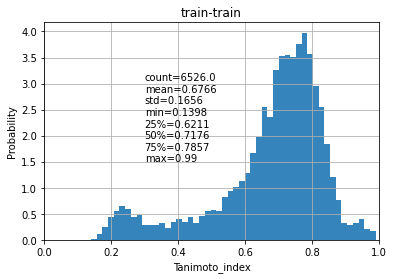

In [57]:
plot_pIC50_sort(df1, name='train-train')

Вывод: 
- В результате сравнения обучающей и тестовой выборке по similarity было найдено 93 соединения из теста, имеющие с соединениями из трэйна  индекса Танимото = 1.0
- При этом это не могли быть одинаковые соединения, поскольку у них разный ChEMBL ID (дубликаты по ChEMBL ID  были удалены в разделе data preparation).
- Оказалось, что данные соединения - стереоизомеры в 3D форме, которые в представлении Моргановских (и других топологических 2D-фингерпринтов) не различимы.
- Появилась необходимость проверить, насколько различаются активности у стереоизомеров (как по классу, так и по значению IC50 в нМ).
- В результате оказалось, что 20 пар соединений имеют разный класс активности. Средняя разница по IC50 у таких соединений составила 33 583 nM, что довольно существенно для расчетов (с учетом того, что граница активности (деление по классам) была определена как 10 000 nM).